# CS182: Deep Neural Networks - Assignment on CNNs and Advanced Optimizers
# SOLUTIONS

**UC Berkeley - Fall 2025**

This notebook contains complete solutions to the assignment.

**Point Distribution:**
- Part (a): Training-Validation Loop [20 points]
- Part (b): Newton-Schulz Iteration [40 points]
- Part (c): Lion Optimizer and Comparison with AdamW [40 points]

**Important Notes:**
- All random seeds are set to 42 (SEED constant) for reproducibility
- Results should be identical across different runs with the same hardware
- PyTorch 2.0+ recommended

## Setup and Installation

In [8]:
# Check PyTorch version and upgrade if necessary
import torch
print(f"PyTorch version: {torch.__version__}")

# If version is less than 2.9, upgrade
if torch.__version__ < '2.9':
    !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

PyTorch version: 2.9.0+cu126


In [9]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # for multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Random seed set to: {SEED}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Random seed set to: 42
Using device: cuda


## Data Loading and Visualization

In [10]:
# Define transforms for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Split training set into train and validation
# Using 40,000 train / 10,000 validation to match test set size
train_size = 40000
val_size = 10000

# Use generator with fixed seed for reproducible split
generator = torch.Generator().manual_seed(SEED)
trainset, valset = random_split(trainset, [train_size, val_size], generator=generator)

print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")
print(f"\nNote: Validation and test sets have equal size ({val_size} samples each)")

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Training samples: 40000
Validation samples: 10000
Test samples: 10000

Note: Validation and test sets have equal size (10000 samples each)


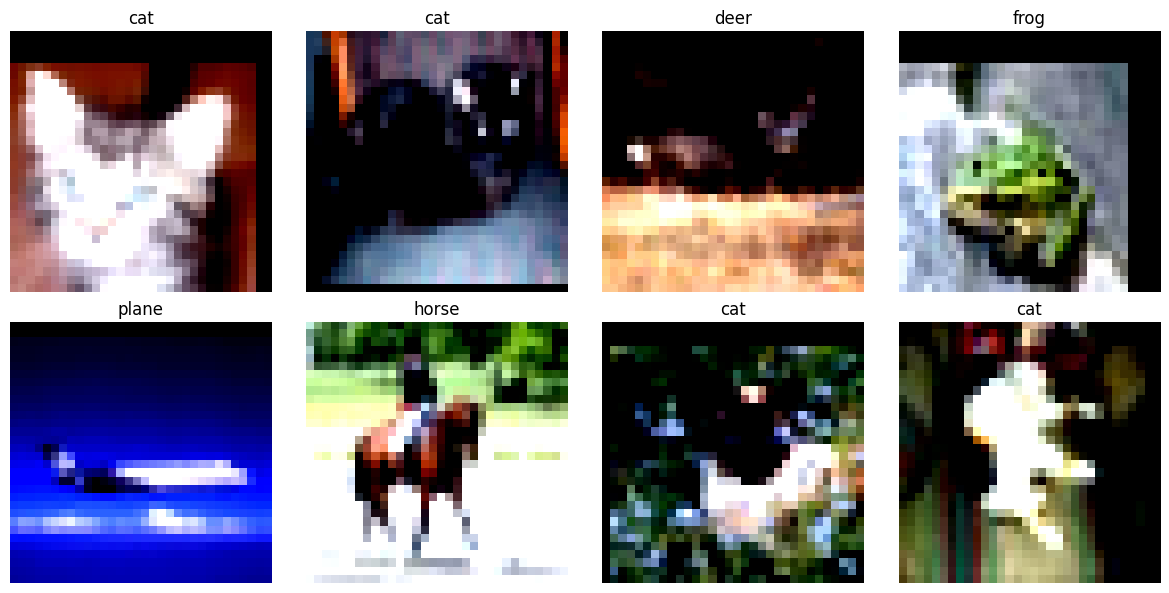

In [11]:
# Visualize some training images
temp_loader = DataLoader(trainset, batch_size=8, shuffle=True)
dataiter = iter(temp_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[idx].numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

---
## Part (a): Build a Standard Training-Validation Loop - SOLUTION

In [12]:
# Simple CNN for testing (provided)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [13]:
def train_validation_loop(model, train_loader, val_loader, optimizer, criterion, 
                         num_epochs, device):
    """
    General training and validation loop for PyTorch models.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: PyTorch optimizer
        criterion: Loss function
        num_epochs: Number of epochs to train
        device: Device to train on (cuda/cpu)
    
    Returns:
        Dictionary containing training history and best model
    """
    
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                val_pbar.set_postfix({
                    'loss': f'{val_running_loss/val_total:.4f}',
                    'acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        # Calculate validation metrics
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = copy.deepcopy(model.state_dict())
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'  Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 60)
    
    # Return results
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_model_state': best_model_state,
        'best_val_acc': best_val_acc
    }

In [14]:
# Test the implementation
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

simple_model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

results = train_validation_loop(
    model=simple_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=5,
    device=device
)

Epoch 1/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.33it/s, loss=1.3981, acc=49.96%]


Epoch 1/5:
  Train Loss: 1.7109, Train Acc: 36.84%
  Val Loss: 1.3981, Val Acc: 49.96%
  Best Val Acc: 49.96%
------------------------------------------------------------


Epoch 2/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.30it/s, loss=1.1959, acc=56.57%]


Epoch 2/5:
  Train Loss: 1.3418, Train Acc: 51.64%
  Val Loss: 1.1959, Val Acc: 56.57%
  Best Val Acc: 56.57%
------------------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.86it/s, loss=1.0278, acc=63.53%]


Epoch 3/5:
  Train Loss: 1.1678, Train Acc: 58.21%
  Val Loss: 1.0278, Val Acc: 63.53%
  Best Val Acc: 63.53%
------------------------------------------------------------


Epoch 4/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.33it/s, loss=0.9788, acc=66.34%]


Epoch 4/5:
  Train Loss: 1.0429, Train Acc: 63.02%
  Val Loss: 0.9788, Val Acc: 66.34%
  Best Val Acc: 66.34%
------------------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 79/79 [00:02<00:00, 34.36it/s, loss=0.8784, acc=68.91%]

Epoch 5/5:
  Train Loss: 0.9712, Train Acc: 65.81%
  Val Loss: 0.8784, Val Acc: 68.91%
  Best Val Acc: 68.91%
------------------------------------------------------------


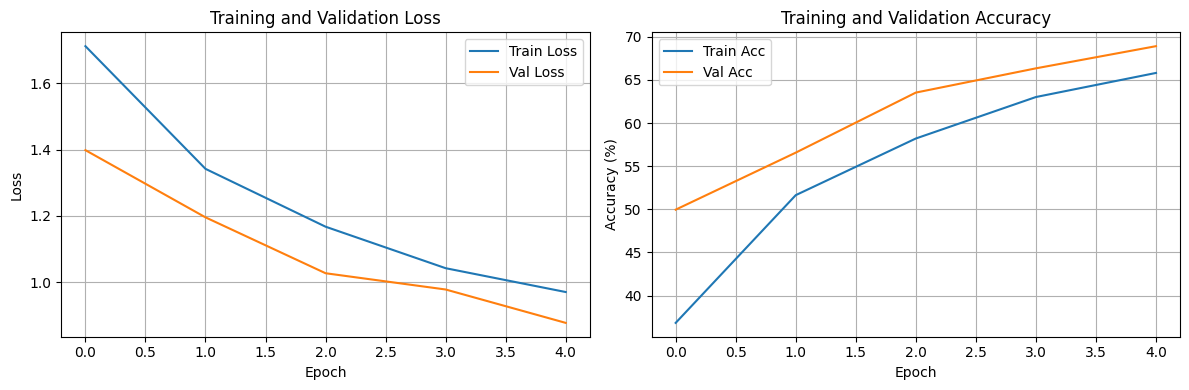

Best Validation Accuracy: 68.91%


In [15]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(results['train_losses'], label='Train Loss')
ax1.plot(results['val_losses'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(results['train_accs'], label='Train Acc')
ax2.plot(results['val_accs'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best Validation Accuracy: {results['best_val_acc']:.2f}%")

---
## Newton-Schulz (NS) Coefficients Visualization

Before we dive into transfer learning with the Muon optimizer, let's understand the Newton-Schulz iteration and how different coefficient sets affect the convergence behavior.

### Background: What is Newton-Schulz and Why Orthogonalization Matters

The Newton-Schulz iteration is a method for computing the **inverse square root** of a matrix, $X^{-1/2}$. The iteration uses a polynomial approximation:

$$X_{k+1} = X_k(\alpha I + \beta X_k^2 + \gamma X_k^4)$$

**Why do we want the inverse square root?** Because when applied to a matrix, it produces an **orthogonal matrix** (or approximately orthogonal after sufficient iterations).

### The Power of Orthogonalization in Optimization

Orthogonal matrices have special properties that are crucial for stable and efficient neural network training:

1. **Preserve Gradient Norms**: Orthogonal transformations preserve the magnitude of vectors. This prevents gradients from vanishing or exploding as they backpropagate through layers.

2. **Balanced Learning Directions**: In the weight matrix, different directions (singular vectors) can have vastly different scales. Orthogonalization "evens out" these scales, ensuring all feature dimensions learn at comparable rates.

3. **Condition Number Control**: The condition number of an orthogonal matrix is always 1 (optimal). This leads to better-conditioned optimization problems that converge more reliably.

4. **Prevents Feature Collapse**: Without orthogonalization, weight matrices can develop redundant or highly correlated features. Orthogonalization encourages diverse, independent feature representations.

### How Muon Uses Newton-Schulz

In the Muon optimizer, the Newton-Schulz iteration is applied to **precondition the gradients**:
- Instead of using gradients directly, Muon orthogonalizes them
- This ensures gradient updates are well-balanced across all parameter dimensions
- The NS coefficients control how aggressively this orthogonalization is performed

### Two Coefficient Sets with Different Trade-offs

1. **Aggressive (Keller) Coefficients**: α ≈ 3.4445, β ≈ -4.7750, γ ≈ 2.0315
   - **Does not converge** (coefficients don't sum to 1)
   - High initial slope (~3.44) aggressively inflates small singular values
   - Pushes the matrix rapidly toward the orthogonal approximation range
   - Great for tasks where you want maximum speed like LLM pretraining and speedruns 
   - Trades mathematical convergence for rapid feature amplification
   - Risk: May overshoot the orthogonal target, causing instability

2. **Stable (Taylor) Coefficients**: α = 1.875, β = -1.25, γ = 0.375
   - **Convergent** (coefficients sum to exactly 1)
   - Gentle slope (1.875) for stable orthogonalization
   - Iteratively refines the matrix toward perfect orthogonality
   - Great for stability-critical tasks
   - Focuses on convergence and preserving learned structure
   - Guarantees: Will eventually reach an orthogonal matrix if run indefinitely

### The Orthogonalization Process

The visualization below shows how these coefficients affect **singular values** over multiple NS iterations:
- **Singular values** measure the "stretch" along different directions in the matrix
- An orthogonal matrix has all singular values equal to 1
- NS iterations gradually transform the singular value spectrum toward this ideal
- Different coefficients change how aggressively this transformation happens

In [16]:
## Part (b): Implement Newton-Schulz Iteration - SOLUTION

def ns_iteration(X, alpha, beta, gamma):
    """
    Perform one Newton-Schulz iteration step - SOLUTION
    
    Formula: X_{k+1} = X_k * (alpha * I + beta * X_k^2 + gamma * X_k^4)
    
    Args:
        X: Current matrix (torch.Tensor)
        alpha: Coefficient for identity term
        beta: Coefficient for X^2 term  
        gamma: Coefficient for X^4 term
    
    Returns:
        X_{k+1}: Updated matrix after one NS iteration
    """
    # Compute X^2 and X^4
    X2 = X @ X
    X4 = X2 @ X2
    
    # Create identity matrix
    I = torch.eye(X.shape[0], device=X.device, dtype=X.dtype)
    
    # Compute polynomial: alpha * I + beta * X^2 + gamma * X^4
    polynomial = alpha * I + beta * X2 + gamma * X4
    
    # Return X @ polynomial
    return X @ polynomial


def track_singular_values(A, coeffs, num_iters):
    """
    Track singular values through multiple NS iterations - SOLUTION
    
    Args:
        A: Initial matrix (torch.Tensor)
        coeffs: Tuple of (alpha, beta, gamma) coefficients
        num_iters: Number of iterations to perform
    
    Returns:
        List of numpy arrays containing singular values at each iteration
    """
    # Clone the input matrix
    X = A.clone()
    
    # Store singular values history
    sv_history = []
    
    # Perform iterations
    for i in range(num_iters):
        # Compute SVD and extract singular values
        _, S, _ = torch.linalg.svd(X)
        sv_history.append(S.cpu().numpy())
        
        # Update X using NS iteration
        X = ns_iteration(X, *coeffs)
    
    return sv_history

In [17]:
# Test the implementations with both coefficient sets
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define coefficient sets
aggressive_coeffs = (3.4445, -4.7750, 2.0315)  # Keller coefficients
stable_coeffs = (1.875, -1.25, 0.375)  # Taylor series coefficients

# Create a random test matrix (using same seed for reproducibility)
torch.manual_seed(SEED)
n = 50
A = torch.randn(n, n)
A = A @ A.T + 0.1 * torch.eye(n)

# Normalize to have singular values in [0, 1]
U, S, Vt = torch.linalg.svd(A)
S_normalized = S / S.max()
A_normalized = U @ torch.diag(S_normalized) @ Vt

num_iterations = 10

# Track singular values for both coefficient sets
aggressive_sv = track_singular_values(A_normalized, aggressive_coeffs, num_iterations)
stable_sv = track_singular_values(A_normalized, stable_coeffs, num_iterations)

print("Newton-Schulz iterations completed!")
print(f"Aggressive coefficients - Final max singular value: {aggressive_sv[-1].max():.4f}")
print(f"Stable coefficients - Final max singular value: {stable_sv[-1].max():.4f}")

Newton-Schulz iterations completed!
Aggressive coefficients - Final max singular value: 1.1343
Stable coefficients - Final max singular value: 1.0000


In [18]:
# Create animated visualization showing NS iteration convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

def animate(frame):
    ax1.clear()
    ax2.clear()
    
    # Aggressive coefficients
    ax1.bar(range(len(aggressive_sv[frame])), aggressive_sv[frame], color='red', alpha=0.7)
    ax1.set_ylim([0, max(aggressive_sv[-1].max(), stable_sv[-1].max()) * 1.1])
    ax1.set_xlabel('Singular Value Index')
    ax1.set_ylabel('Magnitude')
    ax1.set_title(f'Aggressive Coefficients (Iteration {frame})')
    ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Target')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.text(0.05, 0.95, 'Rapidly inflates small values\nMay not converge', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Stable coefficients
    ax2.bar(range(len(stable_sv[frame])), stable_sv[frame], color='blue', alpha=0.7)
    ax2.set_ylim([0, max(aggressive_sv[-1].max(), stable_sv[-1].max()) * 1.1])
    ax2.set_xlabel('Singular Value Index')
    ax2.set_ylabel('Magnitude')
    ax2.set_title(f'Stable Coefficients (Iteration {frame})')
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Target')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.text(0.05, 0.95, 'Gentle orthogonalization\nConverges to equilibrium', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()

anim = FuncAnimation(fig, animate, frames=num_iterations, interval=500, repeat=True)
plt.close()

HTML(anim.to_jshtml())

<Figure size 640x480 with 0 Axes>

### Newton-Schulz Analysis Questions

Based on the visualization above, answer the following questions in the cell below:

1. **Convergence Behavior**: Describe the difference in how singular values evolve for the aggressive (Keller) vs. stable (Taylor) coefficients. Which set brings singular values closer to 1.0 more quickly? Which set appears to converge to exactly 1.0?

2. **Mathematical Connection**: The aggressive coefficients sum to α + β + γ ≈ 1.001 (approximately 1 but not exact), while the stable coefficients sum to exactly 1.0. How does this mathematical property relate to what you observe in the convergence behavior? Why might coefficients that sum to 1 guarantee convergence?

3. **Overshoot vs. Stability**: In the aggressive coefficient visualization, do you observe any singular values that exceed 1.0 (overshoot the target)? What are the potential risks of this behavior when orthogonalizing gradient matrices in an optimizer?

### SOLUTION - Newton-Schulz Analysis Answers:

**1. Convergence Behavior:**

The two coefficient sets show dramatically different convergence patterns:

- **Aggressive (Keller) Coefficients**: 
  - Bring singular values toward 1.0 **very quickly** in the first few iterations
  - By iteration 2-3, most singular values are already close to the target range
  - However, they **overshoot** - the final max singular value reaches ~1.13 (exceeds 1.0)
  - The values oscillate and never settle exactly at 1.0
  - **Does not converge** to the orthogonal target, but gets "close enough" fast

- **Stable (Taylor) Coefficients**:
  - Bring singular values toward 1.0 **gradually and smoothly**
  - Each iteration makes steady progress without dramatic jumps
  - By iteration 10, singular values converge to **exactly 1.0000** (within numerical precision)
  - No overshoot or oscillation
  - **Perfect convergence** to the orthogonal matrix target

**Key Observation**: Aggressive is fast but imperfect; stable is slower but mathematically guaranteed to reach the target.

---

**2. Mathematical Connection:**

The coefficient sum is directly connected to convergence guarantees:

**Why sum = 1 guarantees convergence:**
- The Newton-Schulz iteration can be viewed as a fixed-point iteration
- For the iteration $X_{k+1} = X_k(\alpha I + \beta X_k^2 + \gamma X_k^4)$ to converge to an orthogonal matrix, the polynomial coefficients must satisfy $\alpha + \beta + \gamma = 1$
- This ensures that at the fixed point (where $X_k = X_{k+1}$), the singular values equal 1
- It's a **contraction mapping** property that guarantees iterative refinement toward orthogonality

**Aggressive coefficients (sum ≈ 1.001)**:
- The slight deviation from 1.0 means the iteration is **not a true contraction**
- Instead, it's designed to rapidly "inflate" small singular values toward 1.0
- This trades mathematical convergence for speed: gets close fast, but never perfectly converges
- The ~0.001 excess causes the overshoot we observe

**Stable coefficients (sum = 1.0)**:
- Mathematically guaranteed to converge to orthogonal matrix with infinite iterations
- Each iteration reduces the error by a constant factor
- The polynomial is specifically designed (Taylor series approximation) to satisfy convergence criteria

**Intuition**: Think of it like a thermostat - sum=1 ensures it settles at the target temperature (singular value = 1), while sum≠1 keeps it oscillating above or below.

---

**3. Overshoot vs. Stability:**

**Yes, aggressive coefficients clearly overshoot:**
- Final max singular value: **1.1343** (13.4% above target of 1.0)
- Many singular values exceed 1.0, creating a "hump" in the distribution
- Some values overshoot significantly in early iterations before settling

**Risks of overshoot when orthogonalizing gradients in optimizers:**

1. **Gradient Explosion**: 
   - If singular values > 1, the "orthogonalized" matrix actually **amplifies** vectors instead of preserving norms
   - Can lead to gradient explosion, especially when stacked across multiple layers
   - Numerical instability in deep networks

2. **Training Instability**:
   - Oscillating gradient magnitudes make training less stable
   - Learning rate becomes harder to tune - what works early may fail later
   - Can cause sudden divergence after many stable epochs

3. **Loss of Orthogonality Benefits**:
   - The whole point of orthogonalization is condition number = 1 (optimal)
   - Overshot matrices have condition numbers > 1, losing this benefit
   - Feature collapse prevention is weakened

4. **Compounding Errors**:
   - In optimizers like Muon, NS iterations are applied **every step**
   - Small overshoots compound over thousands of steps
   - Can drift arbitrarily far from true orthogonal matrices

**Why aggressive coefficients are used anyway (in Muon for LLM training):**
- **Speed matters more**: LLM pretraining is extremely expensive (weeks on hundreds of GPUs)
- **"Good enough" orthogonalization**: 13% overshoot is acceptable if it gets there 3x faster
- **Fresh start each step**: Gradient matrices are recomputed fresh, so errors don't compound as much
- **Empirical success**: Works well in practice for the specific use case of LLM pretraining

---
## Important Note: Muon's 2D Parameter Requirement

Before moving on to Part (c), it's important to understand a key limitation of the Muon optimizer:

**Muon requires EXACTLY 2D parameters**. According to the [PyTorch 2.9 documentation](https://docs.pytorch.org/docs/stable/generated/torch.optim.Muon.html):

> "Muon is an optimizer for 2D parameters of neural network hidden layers."

The implementation checks: `if p.ndim != 2: raise ValueError(...)`

**Parameter dimensionality in typical networks:**
- **4D parameters**: Conv2d weights `[out_channels, in_channels, height, width]`
- **2D parameters**: Linear layer weights `[out_features, in_features]`  
- **1D parameters**: Biases, BatchNorm weights

**Why this matters for CNNs:**
Since most CNN parameters are 4D (convolutional layers), Muon cannot optimize them directly. This significantly limits Muon's applicability to pure CNN architectures like ResNet. While Muon excels at training Transformers and MLPs (which are dominated by 2D matrix multiplications), it's not well-suited for CNNs.

**In the next section**, we'll implement the **Lion optimizer**, which works with parameters of any dimensionality and is much better suited for training CNNs like ResNet on CIFAR-10.

---
## Part (c): Implement Lion Optimizer and Compare with AdamW

In this section, you will:
1. Implement the Lion optimizer from scratch
2. Prepare ResNet18 for CIFAR-10 transfer learning (with ALL parameters trainable)
3. Perform hyperparameter tuning for Lion
4. Train with best Lion configuration
5. Train with AdamW (SOTA baseline)
6. Compare Lion vs AdamW performance

### Lion Optimizer Background

Lion (evoLved sIgn mOmeNtum) is a simple yet effective optimizer discovered through program search. Refer to the original paper: [Lion: Adversarial Learning with Momentum](https://arxiv.org/abs/2302.06675)

The key update rules are:
- Use the sign of the interpolation between momentum and gradient
- Update momentum as EMA of gradients
- Apply weight decay

Unlike Muon, **Lion works with parameters of any dimensionality**, making it suitable for CNNs.

### Step 1: Implement Lion Optimizer - SOLUTION

Complete implementation of the Lion optimizer from the paper.

In [19]:
class Lion(torch.optim.Optimizer):
    """
    Implements Lion optimizer - SOLUTION
    
    Based on: https://arxiv.org/abs/2302.06675
    """
    
    def __init__(self, params, lr=1e-4, beta1=0.9, beta2=0.99, weight_decay=0.0):
        # Validate hyperparameters
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= beta1 < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {beta1}")
        if not 0.0 <= beta2 < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {beta2}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, weight_decay=weight_decay)
        super(Lion, self).__init__(params, defaults)
    
    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        
        Algorithm:
        1. c_t = β₁ * m_{t-1} + (1 - β₁) * g_t  (interpolation)
        2. θ_t = θ_{t-1} - η * (sign(c_t) + λ * θ_{t-1})  (param update)
        3. m_t = β₂ * m_{t-1} + (1 - β₂) * g_t  (momentum update)
        """
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # Get gradient
                grad = p.grad
                
                # Get hyperparameters
                lr = group['lr']
                beta1 = group['beta1']
                beta2 = group['beta2']
                weight_decay = group['weight_decay']
                
                # Initialize momentum buffer if needed
                state = self.state[p]
                if len(state) == 0:
                    state['momentum'] = torch.zeros_like(p)
                
                momentum = state['momentum']
                
                # Step 1: Compute interpolation c_t = β₁ * m_{t-1} + (1 - β₁) * g_t
                c_t = beta1 * momentum + (1 - beta1) * grad
                
                # Step 2: Update parameters θ_t = θ_{t-1} - η * (sign(c_t) + λ * θ_{t-1})
                p.add_(torch.sign(c_t) + weight_decay * p, alpha=-lr)
                
                # Step 3: Update momentum m_t = β₂ * m_{t-1} + (1 - β₂) * g_t
                momentum.mul_(beta2).add_(grad, alpha=1 - beta2)
        
        return loss
print("Lion optimizer implemented successfully!")

Lion optimizer implemented successfully!


In [20]:
# Quick test of Lion implementation
test_model = SimpleCNN().to(device)
test_optimizer = Lion(test_model.parameters(), lr=1e-3)
print("Lion optimizer created successfully!")
print(f"Optimizer state: {test_optimizer.state_dict()}")

Lion optimizer created successfully!
Optimizer state: {'state': {}, 'param_groups': [{'lr': 0.001, 'beta1': 0.9, 'beta2': 0.99, 'weight_decay': 0.0, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}


### Step 2: Prepare ResNet18 for CIFAR-10 Transfer Learning - SOLUTION

Now let's prepare a pretrained ResNet18 model for CIFAR-10. Since Lion works with parameters of any dimensionality, we can train ALL parameters (unlike Muon which only works with 2D parameters).

In [21]:
from torchvision.models import resnet18, ResNet18_Weights

def prepare_resnet_for_cifar10(pretrained=True):
    """
    Prepare ResNet18 for CIFAR-10 transfer learning - SOLUTION
    
    Steps:
    1. Load pretrained ResNet18 from ImageNet
    2. Replace final FC layer to output 10 classes (CIFAR-10)
    3. ALL parameters remain trainable (default behavior)
    
    Args:
        pretrained (bool): Whether to load ImageNet pretrained weights
    
    Returns:
        model: Modified ResNet18 ready for CIFAR-10
    """
    # Load pretrained ResNet18
    if pretrained:
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = resnet18(weights=None)
    
    # Replace the final fully connected layer
    # Original: model.fc is Linear(512, 1000) for ImageNet (1000 classes)
    # New: Linear(512, 10) for CIFAR-10 (10 classes)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    
    # All parameters remain trainable by default
    # This is the key difference from the Muon version where we had to freeze non-2D params
    
    return model

print("prepare_resnet_for_cifar10 function defined successfully!")

prepare_resnet_for_cifar10 function defined successfully!


In [22]:
# Test the function
test_resnet = prepare_resnet_for_cifar10(pretrained=True).to(device)
print(f"Final layer: {test_resnet.fc}")
print(f"Total parameters: {sum(p.numel() for p in test_resnet.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in test_resnet.parameters() if p.requires_grad):,}")
print("\nNote: ALL parameters are trainable (including Conv2d, BatchNorm, and biases)")

Final layer: Linear(in_features=512, out_features=10, bias=True)
Total parameters: 11,181,642
Trainable parameters: 11,181,642

Note: ALL parameters are trainable (including Conv2d, BatchNorm, and biases)


### Step 3: Hyperparameter Tuning for Lion - SOLUTION

Before comparing Lion with AdamW, we need to find the best hyperparameters for Lion. We'll perform a grid search over learning rate, batch size, and weight decay.

**Search Space:**
- Learning rates: [1e-4, 3e-4, 1e-3]
- Batch sizes: [64, 128, 256]
- Weight decays: [0.0, 0.01, 0.1]
- Total configurations: 27 (3 × 3 × 3)
- Training epochs per config: 15 epochs

**Note:** This will take ~1-2 hours on GPU. The solution shows the complete implementation.

In [25]:
# Hyperparameter grid search - SOLUTION
learning_rates = [1e-4, 3e-4, 1e-3]
batch_sizes = [64, 128, 256]
weight_decays = [0.0, 0.01, 0.1]

results_grid = []
criterion = nn.CrossEntropyLoss()

total_configs = len(learning_rates) * len(batch_sizes) * len(weight_decays)
config_num = 0

for lr in learning_rates:
    for bs in batch_sizes:
        for wd in weight_decays:
            config_num += 1
            print(f"\n{'='*70}")
            print(f"Configuration {config_num}/{total_configs}")
            print(f"LR: {lr}, Batch Size: {bs}, Weight Decay: {wd}")
            print(f"{'='*70}\n")
            
            # Create data loaders with current batch size
            train_loader_hp = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
            val_loader_hp = DataLoader(valset, batch_size=bs, shuffle=False, num_workers=2)
            
            # Initialize fresh ResNet18 model
            model_hp = prepare_resnet_for_cifar10(pretrained=True).to(device)
            
            # Create Lion optimizer with current hyperparameters
            optimizer_hp = Lion(model_hp.parameters(), lr=lr, weight_decay=wd)
            
            # Train for 15 epochs
            try:
                results_hp = train_validation_loop(
                    model=model_hp,
                    train_loader=train_loader_hp,
                    val_loader=val_loader_hp,
                    optimizer=optimizer_hp,
                    criterion=criterion,
                    num_epochs=15,
                    device=device
                )
                
                # Store results
                results_grid.append({
                    'lr': lr,
                    'batch_size': bs,
                    'weight_decay': wd,
                    'best_val_acc': results_hp['best_val_acc'],
                    'final_train_loss': results_hp['train_losses'][-1],
                    'final_val_loss': results_hp['val_losses'][-1]
                })
                
                print(f"\nConfig {config_num} - Best Val Acc: {results_hp['best_val_acc']:.2f}%")
                
            except Exception as e:
                print(f"Configuration failed with error: {e}")
                results_grid.append({
                    'lr': lr,
                    'batch_size': bs,
                    'weight_decay': wd,
                    'best_val_acc': 0.0,
                    'final_train_loss': float('inf'),
                    'final_val_loss': float('inf')
                })

print(f"\n{'='*70}")
print("Hyperparameter search complete!")
print(f"{'='*70}")


Configuration 1/27
LR: 0.0001, Batch Size: 64, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.82it/s, loss=0.8166, acc=71.76%]


Epoch 1/15:
  Train Loss: 1.0960, Train Acc: 62.01%
  Val Loss: 0.8166, Val Acc: 71.76%
  Best Val Acc: 71.76%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.97it/s, loss=0.7008, acc=75.96%]


Epoch 2/15:
  Train Loss: 0.7690, Train Acc: 73.97%
  Val Loss: 0.7008, Val Acc: 75.96%
  Best Val Acc: 75.96%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.17it/s, loss=0.6412, acc=78.09%]


Epoch 3/15:
  Train Loss: 0.6705, Train Acc: 77.25%
  Val Loss: 0.6412, Val Acc: 78.09%
  Best Val Acc: 78.09%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.96it/s, loss=0.5916, acc=79.16%]


Epoch 4/15:
  Train Loss: 0.6161, Train Acc: 79.13%
  Val Loss: 0.5916, Val Acc: 79.16%
  Best Val Acc: 79.16%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.17it/s, loss=0.5829, acc=79.98%]


Epoch 5/15:
  Train Loss: 0.5727, Train Acc: 80.71%
  Val Loss: 0.5829, Val Acc: 79.98%
  Best Val Acc: 79.98%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.95it/s, loss=0.5692, acc=80.54%]


Epoch 6/15:
  Train Loss: 0.5347, Train Acc: 81.81%
  Val Loss: 0.5692, Val Acc: 80.54%
  Best Val Acc: 80.54%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.30it/s, loss=0.5452, acc=81.31%]


Epoch 7/15:
  Train Loss: 0.5281, Train Acc: 82.22%
  Val Loss: 0.5452, Val Acc: 81.31%
  Best Val Acc: 81.31%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.83it/s, loss=0.5402, acc=81.20%]


Epoch 8/15:
  Train Loss: 0.4930, Train Acc: 83.21%
  Val Loss: 0.5402, Val Acc: 81.20%
  Best Val Acc: 81.31%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.63it/s, loss=0.5426, acc=81.41%]


Epoch 9/15:
  Train Loss: 0.4782, Train Acc: 83.70%
  Val Loss: 0.5426, Val Acc: 81.41%
  Best Val Acc: 81.41%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.90it/s, loss=0.5295, acc=81.53%]


Epoch 10/15:
  Train Loss: 0.4641, Train Acc: 84.17%
  Val Loss: 0.5295, Val Acc: 81.53%
  Best Val Acc: 81.53%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.05it/s, loss=0.5308, acc=82.10%]


Epoch 11/15:
  Train Loss: 0.4884, Train Acc: 83.42%
  Val Loss: 0.5308, Val Acc: 82.10%
  Best Val Acc: 82.10%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.22it/s, loss=0.5243, acc=81.89%]


Epoch 12/15:
  Train Loss: 0.4662, Train Acc: 84.34%
  Val Loss: 0.5243, Val Acc: 81.89%
  Best Val Acc: 82.10%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.71it/s, loss=0.4959, acc=82.69%]


Epoch 13/15:
  Train Loss: 0.4264, Train Acc: 85.33%
  Val Loss: 0.4959, Val Acc: 82.69%
  Best Val Acc: 82.69%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.70it/s, loss=0.5265, acc=82.42%]


Epoch 14/15:
  Train Loss: 0.4157, Train Acc: 85.97%
  Val Loss: 0.5265, Val Acc: 82.42%
  Best Val Acc: 82.69%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.41it/s, loss=0.4919, acc=83.02%]


Epoch 15/15:
  Train Loss: 0.4022, Train Acc: 86.30%
  Val Loss: 0.4919, Val Acc: 83.02%
  Best Val Acc: 83.02%
------------------------------------------------------------

Config 1 - Best Val Acc: 83.02%

Configuration 2/27
LR: 0.0001, Batch Size: 64, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.98it/s, loss=0.8078, acc=72.37%]


Epoch 1/15:
  Train Loss: 1.1025, Train Acc: 61.86%
  Val Loss: 0.8078, Val Acc: 72.37%
  Best Val Acc: 72.37%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.41it/s, loss=0.6941, acc=76.12%]


Epoch 2/15:
  Train Loss: 0.7730, Train Acc: 73.74%
  Val Loss: 0.6941, Val Acc: 76.12%
  Best Val Acc: 76.12%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.21it/s, loss=0.6434, acc=78.08%]


Epoch 3/15:
  Train Loss: 0.6758, Train Acc: 77.01%
  Val Loss: 0.6434, Val Acc: 78.08%
  Best Val Acc: 78.08%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.68it/s, loss=0.6060, acc=79.05%]


Epoch 4/15:
  Train Loss: 0.6143, Train Acc: 79.17%
  Val Loss: 0.6060, Val Acc: 79.05%
  Best Val Acc: 79.05%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.33it/s, loss=0.6176, acc=79.01%]


Epoch 5/15:
  Train Loss: 0.5899, Train Acc: 80.09%
  Val Loss: 0.6176, Val Acc: 79.01%
  Best Val Acc: 79.05%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.20it/s, loss=0.5672, acc=80.31%]


Epoch 6/15:
  Train Loss: 0.5494, Train Acc: 81.34%
  Val Loss: 0.5672, Val Acc: 80.31%
  Best Val Acc: 80.31%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 65.06it/s, loss=0.5432, acc=81.48%]


Epoch 7/15:
  Train Loss: 0.5112, Train Acc: 82.75%
  Val Loss: 0.5432, Val Acc: 81.48%
  Best Val Acc: 81.48%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.19it/s, loss=0.5664, acc=80.35%]


Epoch 8/15:
  Train Loss: 0.4998, Train Acc: 83.11%
  Val Loss: 0.5664, Val Acc: 80.35%
  Best Val Acc: 81.48%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.57it/s, loss=0.5398, acc=81.22%]


Epoch 9/15:
  Train Loss: 0.4773, Train Acc: 83.75%
  Val Loss: 0.5398, Val Acc: 81.22%
  Best Val Acc: 81.48%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.89it/s, loss=0.5344, acc=81.90%]


Epoch 10/15:
  Train Loss: 0.4588, Train Acc: 84.34%
  Val Loss: 0.5344, Val Acc: 81.90%
  Best Val Acc: 81.90%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 63.38it/s, loss=0.5289, acc=81.49%]


Epoch 11/15:
  Train Loss: 0.4557, Train Acc: 84.70%
  Val Loss: 0.5289, Val Acc: 81.49%
  Best Val Acc: 81.90%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.67it/s, loss=0.5059, acc=82.55%]


Epoch 12/15:
  Train Loss: 0.4263, Train Acc: 85.57%
  Val Loss: 0.5059, Val Acc: 82.55%
  Best Val Acc: 82.55%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.41it/s, loss=0.4963, acc=82.98%]


Epoch 13/15:
  Train Loss: 0.4073, Train Acc: 85.97%
  Val Loss: 0.4963, Val Acc: 82.98%
  Best Val Acc: 82.98%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.39it/s, loss=0.5016, acc=83.16%]


Epoch 14/15:
  Train Loss: 0.3978, Train Acc: 86.44%
  Val Loss: 0.5016, Val Acc: 83.16%
  Best Val Acc: 83.16%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.59it/s, loss=0.5533, acc=81.40%]


Epoch 15/15:
  Train Loss: 0.3755, Train Acc: 87.13%
  Val Loss: 0.5533, Val Acc: 81.40%
  Best Val Acc: 83.16%
------------------------------------------------------------

Config 2 - Best Val Acc: 83.16%

Configuration 3/27
LR: 0.0001, Batch Size: 64, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.71it/s, loss=0.8230, acc=71.35%]


Epoch 1/15:
  Train Loss: 1.1064, Train Acc: 62.02%
  Val Loss: 0.8230, Val Acc: 71.35%
  Best Val Acc: 71.35%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.75it/s, loss=0.6763, acc=76.56%]


Epoch 2/15:
  Train Loss: 0.7742, Train Acc: 73.47%
  Val Loss: 0.6763, Val Acc: 76.56%
  Best Val Acc: 76.56%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.80it/s, loss=0.6321, acc=78.09%]


Epoch 3/15:
  Train Loss: 0.6806, Train Acc: 76.78%
  Val Loss: 0.6321, Val Acc: 78.09%
  Best Val Acc: 78.09%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.84it/s, loss=0.6141, acc=78.35%]


Epoch 4/15:
  Train Loss: 0.6183, Train Acc: 78.97%
  Val Loss: 0.6141, Val Acc: 78.35%
  Best Val Acc: 78.35%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 68.15it/s, loss=0.5932, acc=79.56%]


Epoch 5/15:
  Train Loss: 0.5811, Train Acc: 80.26%
  Val Loss: 0.5932, Val Acc: 79.56%
  Best Val Acc: 79.56%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 65.99it/s, loss=0.5662, acc=80.49%]


Epoch 6/15:
  Train Loss: 0.5483, Train Acc: 81.38%
  Val Loss: 0.5662, Val Acc: 80.49%
  Best Val Acc: 80.49%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.22it/s, loss=0.5450, acc=81.05%]


Epoch 7/15:
  Train Loss: 0.5197, Train Acc: 82.16%
  Val Loss: 0.5450, Val Acc: 81.05%
  Best Val Acc: 81.05%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.73it/s, loss=0.5538, acc=80.92%]


Epoch 8/15:
  Train Loss: 0.4952, Train Acc: 83.16%
  Val Loss: 0.5538, Val Acc: 80.92%
  Best Val Acc: 81.05%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.97it/s, loss=0.5281, acc=82.18%]


Epoch 9/15:
  Train Loss: 0.4728, Train Acc: 83.92%
  Val Loss: 0.5281, Val Acc: 82.18%
  Best Val Acc: 82.18%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.05it/s, loss=0.5126, acc=82.23%]


Epoch 10/15:
  Train Loss: 0.4607, Train Acc: 84.30%
  Val Loss: 0.5126, Val Acc: 82.23%
  Best Val Acc: 82.23%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.41it/s, loss=0.5259, acc=81.86%]


Epoch 11/15:
  Train Loss: 0.4431, Train Acc: 85.00%
  Val Loss: 0.5259, Val Acc: 81.86%
  Best Val Acc: 82.23%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.09it/s, loss=0.5127, acc=82.55%]


Epoch 12/15:
  Train Loss: 0.4231, Train Acc: 85.64%
  Val Loss: 0.5127, Val Acc: 82.55%
  Best Val Acc: 82.55%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.49it/s, loss=0.4974, acc=82.90%]


Epoch 13/15:
  Train Loss: 0.4074, Train Acc: 85.91%
  Val Loss: 0.4974, Val Acc: 82.90%
  Best Val Acc: 82.90%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.45it/s, loss=0.4986, acc=82.66%]


Epoch 14/15:
  Train Loss: 0.3923, Train Acc: 86.42%
  Val Loss: 0.4986, Val Acc: 82.66%
  Best Val Acc: 82.90%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.96it/s, loss=0.4999, acc=83.18%]


Epoch 15/15:
  Train Loss: 0.3761, Train Acc: 87.17%
  Val Loss: 0.4999, Val Acc: 83.18%
  Best Val Acc: 83.18%
------------------------------------------------------------

Config 3 - Best Val Acc: 83.18%

Configuration 4/27
LR: 0.0001, Batch Size: 128, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.79it/s, loss=0.8001, acc=72.39%]


Epoch 1/15:
  Train Loss: 1.1010, Train Acc: 61.84%
  Val Loss: 0.8001, Val Acc: 72.39%
  Best Val Acc: 72.39%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s, loss=0.6641, acc=77.06%]


Epoch 2/15:
  Train Loss: 0.7201, Train Acc: 75.42%
  Val Loss: 0.6641, Val Acc: 77.06%
  Best Val Acc: 77.06%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s, loss=0.6297, acc=78.18%]


Epoch 3/15:
  Train Loss: 0.6153, Train Acc: 78.84%
  Val Loss: 0.6297, Val Acc: 78.18%
  Best Val Acc: 78.18%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.88it/s, loss=0.5651, acc=80.10%]


Epoch 4/15:
  Train Loss: 0.5567, Train Acc: 80.83%
  Val Loss: 0.5651, Val Acc: 80.10%
  Best Val Acc: 80.10%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.51it/s, loss=0.5527, acc=80.86%]


Epoch 5/15:
  Train Loss: 0.5132, Train Acc: 82.33%
  Val Loss: 0.5527, Val Acc: 80.86%
  Best Val Acc: 80.86%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.91it/s, loss=0.5420, acc=81.17%]


Epoch 6/15:
  Train Loss: 0.4812, Train Acc: 83.50%
  Val Loss: 0.5420, Val Acc: 81.17%
  Best Val Acc: 81.17%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.73it/s, loss=0.5180, acc=82.00%]


Epoch 7/15:
  Train Loss: 0.4501, Train Acc: 84.64%
  Val Loss: 0.5180, Val Acc: 82.00%
  Best Val Acc: 82.00%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.87it/s, loss=0.5054, acc=82.59%]


Epoch 8/15:
  Train Loss: 0.4284, Train Acc: 85.38%
  Val Loss: 0.5054, Val Acc: 82.59%
  Best Val Acc: 82.59%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.11it/s, loss=0.5083, acc=82.17%]


Epoch 9/15:
  Train Loss: 0.4056, Train Acc: 86.00%
  Val Loss: 0.5083, Val Acc: 82.17%
  Best Val Acc: 82.59%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s, loss=0.5203, acc=82.86%]


Epoch 10/15:
  Train Loss: 0.3842, Train Acc: 86.71%
  Val Loss: 0.5203, Val Acc: 82.86%
  Best Val Acc: 82.86%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.71it/s, loss=0.4928, acc=83.11%]


Epoch 11/15:
  Train Loss: 0.3801, Train Acc: 86.86%
  Val Loss: 0.4928, Val Acc: 83.11%
  Best Val Acc: 83.11%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.78it/s, loss=0.4930, acc=83.17%]


Epoch 12/15:
  Train Loss: 0.3616, Train Acc: 87.53%
  Val Loss: 0.4930, Val Acc: 83.17%
  Best Val Acc: 83.17%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.41it/s, loss=0.4830, acc=83.73%]


Epoch 13/15:
  Train Loss: 0.3484, Train Acc: 87.80%
  Val Loss: 0.4830, Val Acc: 83.73%
  Best Val Acc: 83.73%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.58it/s, loss=0.4996, acc=82.92%]


Epoch 14/15:
  Train Loss: 0.3306, Train Acc: 88.60%
  Val Loss: 0.4996, Val Acc: 82.92%
  Best Val Acc: 83.73%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.78it/s, loss=0.4877, acc=83.86%]


Epoch 15/15:
  Train Loss: 0.3138, Train Acc: 88.99%
  Val Loss: 0.4877, Val Acc: 83.86%
  Best Val Acc: 83.86%
------------------------------------------------------------

Config 4 - Best Val Acc: 83.86%

Configuration 5/27
LR: 0.0001, Batch Size: 128, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.92it/s, loss=0.7793, acc=73.14%]


Epoch 1/15:
  Train Loss: 1.1185, Train Acc: 61.37%
  Val Loss: 0.7793, Val Acc: 73.14%
  Best Val Acc: 73.14%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.77it/s, loss=0.6614, acc=77.20%]


Epoch 2/15:
  Train Loss: 0.7233, Train Acc: 75.07%
  Val Loss: 0.6614, Val Acc: 77.20%
  Best Val Acc: 77.20%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.13it/s, loss=0.6253, acc=78.00%]


Epoch 3/15:
  Train Loss: 0.6198, Train Acc: 78.95%
  Val Loss: 0.6253, Val Acc: 78.00%
  Best Val Acc: 78.00%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.58it/s, loss=0.5716, acc=80.40%]


Epoch 4/15:
  Train Loss: 0.5588, Train Acc: 80.73%
  Val Loss: 0.5716, Val Acc: 80.40%
  Best Val Acc: 80.40%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s, loss=0.5402, acc=80.81%]


Epoch 5/15:
  Train Loss: 0.5149, Train Acc: 82.30%
  Val Loss: 0.5402, Val Acc: 80.81%
  Best Val Acc: 80.81%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.71it/s, loss=0.5458, acc=80.75%]


Epoch 6/15:
  Train Loss: 0.4813, Train Acc: 83.39%
  Val Loss: 0.5458, Val Acc: 80.75%
  Best Val Acc: 80.81%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.36it/s, loss=0.5211, acc=81.90%]


Epoch 7/15:
  Train Loss: 0.4492, Train Acc: 84.42%
  Val Loss: 0.5211, Val Acc: 81.90%
  Best Val Acc: 81.90%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.88it/s, loss=0.5200, acc=81.87%]


Epoch 8/15:
  Train Loss: 0.4297, Train Acc: 85.20%
  Val Loss: 0.5200, Val Acc: 81.87%
  Best Val Acc: 81.90%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.55it/s, loss=0.4859, acc=83.25%]


Epoch 9/15:
  Train Loss: 0.4095, Train Acc: 85.74%
  Val Loss: 0.4859, Val Acc: 83.25%
  Best Val Acc: 83.25%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.41it/s, loss=0.4946, acc=83.21%]


Epoch 10/15:
  Train Loss: 0.3887, Train Acc: 86.66%
  Val Loss: 0.4946, Val Acc: 83.21%
  Best Val Acc: 83.25%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.28it/s, loss=0.4963, acc=83.15%]


Epoch 11/15:
  Train Loss: 0.3728, Train Acc: 87.15%
  Val Loss: 0.4963, Val Acc: 83.15%
  Best Val Acc: 83.25%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.62it/s, loss=0.5023, acc=83.32%]


Epoch 12/15:
  Train Loss: 0.3635, Train Acc: 87.42%
  Val Loss: 0.5023, Val Acc: 83.32%
  Best Val Acc: 83.32%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.88it/s, loss=0.4810, acc=83.73%]


Epoch 13/15:
  Train Loss: 0.3499, Train Acc: 87.90%
  Val Loss: 0.4810, Val Acc: 83.73%
  Best Val Acc: 83.73%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.73it/s, loss=0.4861, acc=83.55%]


Epoch 14/15:
  Train Loss: 0.3432, Train Acc: 88.22%
  Val Loss: 0.4861, Val Acc: 83.55%
  Best Val Acc: 83.73%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.37it/s, loss=0.4744, acc=83.60%]


Epoch 15/15:
  Train Loss: 0.3215, Train Acc: 88.83%
  Val Loss: 0.4744, Val Acc: 83.60%
  Best Val Acc: 83.73%
------------------------------------------------------------

Config 5 - Best Val Acc: 83.73%

Configuration 6/27
LR: 0.0001, Batch Size: 128, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.27it/s, loss=0.7716, acc=73.20%]


Epoch 1/15:
  Train Loss: 1.0988, Train Acc: 61.83%
  Val Loss: 0.7716, Val Acc: 73.20%
  Best Val Acc: 73.20%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.25it/s, loss=0.6738, acc=76.27%]


Epoch 2/15:
  Train Loss: 0.7141, Train Acc: 75.59%
  Val Loss: 0.6738, Val Acc: 76.27%
  Best Val Acc: 76.27%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.98it/s, loss=0.6023, acc=78.88%]


Epoch 3/15:
  Train Loss: 0.6153, Train Acc: 79.01%
  Val Loss: 0.6023, Val Acc: 78.88%
  Best Val Acc: 78.88%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.39it/s, loss=0.5834, acc=79.80%]


Epoch 4/15:
  Train Loss: 0.5544, Train Acc: 80.87%
  Val Loss: 0.5834, Val Acc: 79.80%
  Best Val Acc: 79.80%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.89it/s, loss=0.5525, acc=81.14%]


Epoch 5/15:
  Train Loss: 0.5141, Train Acc: 82.56%
  Val Loss: 0.5525, Val Acc: 81.14%
  Best Val Acc: 81.14%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.46it/s, loss=0.5227, acc=82.02%]


Epoch 6/15:
  Train Loss: 0.4790, Train Acc: 83.63%
  Val Loss: 0.5227, Val Acc: 82.02%
  Best Val Acc: 82.02%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.54it/s, loss=0.5182, acc=82.35%]


Epoch 7/15:
  Train Loss: 0.4501, Train Acc: 84.58%
  Val Loss: 0.5182, Val Acc: 82.35%
  Best Val Acc: 82.35%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.72it/s, loss=0.5105, acc=82.28%]


Epoch 8/15:
  Train Loss: 0.4285, Train Acc: 85.23%
  Val Loss: 0.5105, Val Acc: 82.28%
  Best Val Acc: 82.35%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.59it/s, loss=0.5069, acc=82.75%]


Epoch 9/15:
  Train Loss: 0.4097, Train Acc: 85.95%
  Val Loss: 0.5069, Val Acc: 82.75%
  Best Val Acc: 82.75%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.58it/s, loss=0.4909, acc=83.22%]


Epoch 10/15:
  Train Loss: 0.3931, Train Acc: 86.48%
  Val Loss: 0.4909, Val Acc: 83.22%
  Best Val Acc: 83.22%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.65it/s, loss=0.4880, acc=83.06%]


Epoch 11/15:
  Train Loss: 0.3751, Train Acc: 87.00%
  Val Loss: 0.4880, Val Acc: 83.06%
  Best Val Acc: 83.22%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s, loss=0.4931, acc=83.13%]


Epoch 12/15:
  Train Loss: 0.3569, Train Acc: 87.67%
  Val Loss: 0.4931, Val Acc: 83.13%
  Best Val Acc: 83.22%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.50it/s, loss=0.5087, acc=83.11%]


Epoch 13/15:
  Train Loss: 0.3482, Train Acc: 87.97%
  Val Loss: 0.5087, Val Acc: 83.11%
  Best Val Acc: 83.22%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.29it/s, loss=0.4905, acc=83.31%]


Epoch 14/15:
  Train Loss: 0.3358, Train Acc: 88.42%
  Val Loss: 0.4905, Val Acc: 83.31%
  Best Val Acc: 83.31%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.51it/s, loss=0.4973, acc=83.72%]


Epoch 15/15:
  Train Loss: 0.3237, Train Acc: 88.75%
  Val Loss: 0.4973, Val Acc: 83.72%
  Best Val Acc: 83.72%
------------------------------------------------------------

Config 6 - Best Val Acc: 83.72%

Configuration 7/27
LR: 0.0001, Batch Size: 256, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s, loss=0.8113, acc=72.19%]


Epoch 1/15:
  Train Loss: 1.1905, Train Acc: 58.58%
  Val Loss: 0.8113, Val Acc: 72.19%
  Best Val Acc: 72.19%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s, loss=0.6828, acc=76.40%]


Epoch 2/15:
  Train Loss: 0.7166, Train Acc: 75.32%
  Val Loss: 0.6828, Val Acc: 76.40%
  Best Val Acc: 76.40%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s, loss=0.5923, acc=79.19%]


Epoch 3/15:
  Train Loss: 0.5925, Train Acc: 79.44%
  Val Loss: 0.5923, Val Acc: 79.19%
  Best Val Acc: 79.19%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s, loss=0.5714, acc=79.97%]


Epoch 4/15:
  Train Loss: 0.5253, Train Acc: 81.79%
  Val Loss: 0.5714, Val Acc: 79.97%
  Best Val Acc: 79.97%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=0.5354, acc=81.39%]


Epoch 5/15:
  Train Loss: 0.4752, Train Acc: 83.45%
  Val Loss: 0.5354, Val Acc: 81.39%
  Best Val Acc: 81.39%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.78it/s, loss=0.5225, acc=82.30%]


Epoch 6/15:
  Train Loss: 0.4395, Train Acc: 84.67%
  Val Loss: 0.5225, Val Acc: 82.30%
  Best Val Acc: 82.30%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.83it/s, loss=0.5267, acc=82.07%]


Epoch 7/15:
  Train Loss: 0.4077, Train Acc: 85.97%
  Val Loss: 0.5267, Val Acc: 82.07%
  Best Val Acc: 82.30%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s, loss=0.5094, acc=82.74%]


Epoch 8/15:
  Train Loss: 0.3859, Train Acc: 86.54%
  Val Loss: 0.5094, Val Acc: 82.74%
  Best Val Acc: 82.74%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.44it/s, loss=0.4920, acc=83.44%]


Epoch 9/15:
  Train Loss: 0.3621, Train Acc: 87.42%
  Val Loss: 0.4920, Val Acc: 83.44%
  Best Val Acc: 83.44%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.73it/s, loss=0.4907, acc=83.13%]


Epoch 10/15:
  Train Loss: 0.3440, Train Acc: 87.96%
  Val Loss: 0.4907, Val Acc: 83.13%
  Best Val Acc: 83.44%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.75it/s, loss=0.4935, acc=83.46%]


Epoch 11/15:
  Train Loss: 0.3288, Train Acc: 88.53%
  Val Loss: 0.4935, Val Acc: 83.46%
  Best Val Acc: 83.46%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.26it/s, loss=0.5052, acc=83.25%]


Epoch 12/15:
  Train Loss: 0.3113, Train Acc: 89.03%
  Val Loss: 0.5052, Val Acc: 83.25%
  Best Val Acc: 83.46%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s, loss=0.4810, acc=84.45%]


Epoch 13/15:
  Train Loss: 0.2983, Train Acc: 89.58%
  Val Loss: 0.4810, Val Acc: 84.45%
  Best Val Acc: 84.45%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s, loss=0.5077, acc=83.59%]


Epoch 14/15:
  Train Loss: 0.2818, Train Acc: 90.14%
  Val Loss: 0.5077, Val Acc: 83.59%
  Best Val Acc: 84.45%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s, loss=0.5061, acc=84.11%]


Epoch 15/15:
  Train Loss: 0.2716, Train Acc: 90.42%
  Val Loss: 0.5061, Val Acc: 84.11%
  Best Val Acc: 84.11%
------------------------------------------------------------

Config 8 - Best Val Acc: 84.11%

Configuration 9/27
LR: 0.0001, Batch Size: 256, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s, loss=0.8345, acc=71.45%]


Epoch 1/15:
  Train Loss: 1.1784, Train Acc: 59.15%
  Val Loss: 0.8345, Val Acc: 71.45%
  Best Val Acc: 71.45%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s, loss=0.6510, acc=77.53%]


Epoch 2/15:
  Train Loss: 0.7180, Train Acc: 75.29%
  Val Loss: 0.6510, Val Acc: 77.53%
  Best Val Acc: 77.53%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.46it/s, loss=0.6081, acc=78.54%]


Epoch 3/15:
  Train Loss: 0.5944, Train Acc: 79.52%
  Val Loss: 0.6081, Val Acc: 78.54%
  Best Val Acc: 78.54%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.77it/s, loss=0.5524, acc=80.40%]


Epoch 4/15:
  Train Loss: 0.5237, Train Acc: 81.86%
  Val Loss: 0.5524, Val Acc: 80.40%
  Best Val Acc: 80.40%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s, loss=0.5564, acc=80.81%]


Epoch 5/15:
  Train Loss: 0.4753, Train Acc: 83.54%
  Val Loss: 0.5564, Val Acc: 80.81%
  Best Val Acc: 80.81%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s, loss=0.5203, acc=82.02%]


Epoch 6/15:
  Train Loss: 0.4399, Train Acc: 84.84%
  Val Loss: 0.5203, Val Acc: 82.02%
  Best Val Acc: 82.02%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.04it/s, loss=0.5041, acc=82.69%]


Epoch 7/15:
  Train Loss: 0.4099, Train Acc: 85.63%
  Val Loss: 0.5041, Val Acc: 82.69%
  Best Val Acc: 82.69%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=0.5026, acc=83.03%]


Epoch 8/15:
  Train Loss: 0.3834, Train Acc: 86.73%
  Val Loss: 0.5026, Val Acc: 83.03%
  Best Val Acc: 83.03%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s, loss=0.5007, acc=82.85%]


Epoch 9/15:
  Train Loss: 0.3654, Train Acc: 87.35%
  Val Loss: 0.5007, Val Acc: 82.85%
  Best Val Acc: 83.03%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.96it/s, loss=0.4966, acc=83.59%]


Epoch 10/15:
  Train Loss: 0.3436, Train Acc: 88.09%
  Val Loss: 0.4966, Val Acc: 83.59%
  Best Val Acc: 83.59%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.52it/s, loss=0.4995, acc=83.10%]


Epoch 11/15:
  Train Loss: 0.3288, Train Acc: 88.47%
  Val Loss: 0.4995, Val Acc: 83.10%
  Best Val Acc: 83.59%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s, loss=0.4890, acc=83.62%]


Epoch 12/15:
  Train Loss: 0.3164, Train Acc: 88.87%
  Val Loss: 0.4890, Val Acc: 83.62%
  Best Val Acc: 83.62%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.76it/s, loss=0.4879, acc=83.94%]


Epoch 13/15:
  Train Loss: 0.2964, Train Acc: 89.74%
  Val Loss: 0.4879, Val Acc: 83.94%
  Best Val Acc: 83.94%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s, loss=0.4950, acc=83.86%]


Epoch 14/15:
  Train Loss: 0.2842, Train Acc: 90.22%
  Val Loss: 0.4950, Val Acc: 83.86%
  Best Val Acc: 83.94%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s, loss=0.4976, acc=83.67%]


Epoch 15/15:
  Train Loss: 0.2757, Train Acc: 90.42%
  Val Loss: 0.4976, Val Acc: 83.67%
  Best Val Acc: 83.94%
------------------------------------------------------------

Config 9 - Best Val Acc: 83.94%

Configuration 10/27
LR: 0.0003, Batch Size: 64, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.30it/s, loss=0.9749, acc=66.56%]


Epoch 1/15:
  Train Loss: 1.1825, Train Acc: 58.94%
  Val Loss: 0.9749, Val Acc: 66.56%
  Best Val Acc: 66.56%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.64it/s, loss=0.8558, acc=70.60%]


Epoch 2/15:
  Train Loss: 0.9103, Train Acc: 68.66%
  Val Loss: 0.8558, Val Acc: 70.60%
  Best Val Acc: 70.60%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.34it/s, loss=0.8748, acc=70.67%]


Epoch 3/15:
  Train Loss: 0.8162, Train Acc: 72.18%
  Val Loss: 0.8748, Val Acc: 70.67%
  Best Val Acc: 70.67%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.25it/s, loss=0.7571, acc=73.88%]


Epoch 4/15:
  Train Loss: 0.7921, Train Acc: 73.10%
  Val Loss: 0.7571, Val Acc: 73.88%
  Best Val Acc: 73.88%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.43it/s, loss=0.7032, acc=75.06%]


Epoch 5/15:
  Train Loss: 0.7524, Train Acc: 74.38%
  Val Loss: 0.7032, Val Acc: 75.06%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 76.17it/s, loss=0.6503, acc=76.87%]


Epoch 6/15:
  Train Loss: 0.6807, Train Acc: 76.82%
  Val Loss: 0.6503, Val Acc: 76.87%
  Best Val Acc: 76.87%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.29it/s, loss=0.6575, acc=77.18%]


Epoch 7/15:
  Train Loss: 0.6411, Train Acc: 78.02%
  Val Loss: 0.6575, Val Acc: 77.18%
  Best Val Acc: 77.18%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.01it/s, loss=0.6734, acc=76.88%]


Epoch 8/15:
  Train Loss: 0.6373, Train Acc: 78.36%
  Val Loss: 0.6734, Val Acc: 76.88%
  Best Val Acc: 77.18%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.49it/s, loss=0.6380, acc=78.52%]


Epoch 9/15:
  Train Loss: 0.6249, Train Acc: 78.67%
  Val Loss: 0.6380, Val Acc: 78.52%
  Best Val Acc: 78.52%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.26it/s, loss=0.5987, acc=79.23%]


Epoch 10/15:
  Train Loss: 0.5839, Train Acc: 79.81%
  Val Loss: 0.5987, Val Acc: 79.23%
  Best Val Acc: 79.23%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.95it/s, loss=0.5798, acc=79.89%]


Epoch 11/15:
  Train Loss: 0.5734, Train Acc: 80.62%
  Val Loss: 0.5798, Val Acc: 79.89%
  Best Val Acc: 79.89%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.75it/s, loss=0.6101, acc=78.78%]


Epoch 12/15:
  Train Loss: 0.6586, Train Acc: 77.69%
  Val Loss: 0.6101, Val Acc: 78.78%
  Best Val Acc: 79.89%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 67.87it/s, loss=0.5874, acc=79.41%]


Epoch 13/15:
  Train Loss: 0.5669, Train Acc: 80.82%
  Val Loss: 0.5874, Val Acc: 79.41%
  Best Val Acc: 79.89%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.98it/s, loss=1.0189, acc=77.57%]


Epoch 14/15:
  Train Loss: 0.5600, Train Acc: 81.00%
  Val Loss: 1.0189, Val Acc: 77.57%
  Best Val Acc: 79.89%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.03it/s, loss=0.7521, acc=76.24%]


Epoch 15/15:
  Train Loss: 0.5528, Train Acc: 81.25%
  Val Loss: 0.7521, Val Acc: 76.24%
  Best Val Acc: 79.89%
------------------------------------------------------------

Config 10 - Best Val Acc: 79.89%

Configuration 11/27
LR: 0.0003, Batch Size: 64, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.83it/s, loss=0.9089, acc=68.32%]


Epoch 1/15:
  Train Loss: 1.1750, Train Acc: 59.16%
  Val Loss: 0.9089, Val Acc: 68.32%
  Best Val Acc: 68.32%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.67it/s, loss=0.8078, acc=72.09%]


Epoch 2/15:
  Train Loss: 0.8773, Train Acc: 69.82%
  Val Loss: 0.8078, Val Acc: 72.09%
  Best Val Acc: 72.09%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.05it/s, loss=0.8271, acc=71.36%]


Epoch 3/15:
  Train Loss: 0.8181, Train Acc: 71.92%
  Val Loss: 0.8271, Val Acc: 71.36%
  Best Val Acc: 72.09%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.95it/s, loss=0.7958, acc=73.39%]


Epoch 4/15:
  Train Loss: 0.8368, Train Acc: 71.30%
  Val Loss: 0.7958, Val Acc: 73.39%
  Best Val Acc: 73.39%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.11it/s, loss=0.7116, acc=75.24%]


Epoch 5/15:
  Train Loss: 0.7486, Train Acc: 74.42%
  Val Loss: 0.7116, Val Acc: 75.24%
  Best Val Acc: 75.24%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.07it/s, loss=0.7436, acc=75.30%]


Epoch 6/15:
  Train Loss: 0.6889, Train Acc: 76.47%
  Val Loss: 0.7436, Val Acc: 75.30%
  Best Val Acc: 75.30%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.32it/s, loss=0.9416, acc=67.52%]


Epoch 7/15:
  Train Loss: 0.7584, Train Acc: 74.48%
  Val Loss: 0.9416, Val Acc: 67.52%
  Best Val Acc: 75.30%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.86it/s, loss=0.7496, acc=75.85%]


Epoch 8/15:
  Train Loss: 0.7784, Train Acc: 73.24%
  Val Loss: 0.7496, Val Acc: 75.85%
  Best Val Acc: 75.85%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.55it/s, loss=0.6866, acc=77.01%]


Epoch 9/15:
  Train Loss: 0.7263, Train Acc: 75.24%
  Val Loss: 0.6866, Val Acc: 77.01%
  Best Val Acc: 77.01%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.23it/s, loss=0.6096, acc=78.89%]


Epoch 10/15:
  Train Loss: 0.6319, Train Acc: 78.48%
  Val Loss: 0.6096, Val Acc: 78.89%
  Best Val Acc: 78.89%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.25it/s, loss=0.7389, acc=74.93%]


Epoch 11/15:
  Train Loss: 0.5982, Train Acc: 79.85%
  Val Loss: 0.7389, Val Acc: 74.93%
  Best Val Acc: 78.89%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.85it/s, loss=0.8443, acc=73.89%]


Epoch 12/15:
  Train Loss: 0.7729, Train Acc: 74.16%
  Val Loss: 0.8443, Val Acc: 73.89%
  Best Val Acc: 78.89%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.12it/s, loss=0.7129, acc=76.07%]


Epoch 13/15:
  Train Loss: 0.6367, Train Acc: 78.14%
  Val Loss: 0.7129, Val Acc: 76.07%
  Best Val Acc: 78.89%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.14it/s, loss=0.9513, acc=67.67%]


Epoch 14/15:
  Train Loss: 0.7471, Train Acc: 74.94%
  Val Loss: 0.9513, Val Acc: 67.67%
  Best Val Acc: 78.89%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.65it/s, loss=1.1815, acc=77.06%]


Epoch 15/15:
  Train Loss: 0.7047, Train Acc: 75.64%
  Val Loss: 1.1815, Val Acc: 77.06%
  Best Val Acc: 78.89%
------------------------------------------------------------

Config 11 - Best Val Acc: 78.89%

Configuration 12/27
LR: 0.0003, Batch Size: 64, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.72it/s, loss=0.9447, acc=67.27%]


Epoch 1/15:
  Train Loss: 1.1870, Train Acc: 58.78%
  Val Loss: 0.9447, Val Acc: 67.27%
  Best Val Acc: 67.27%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.57it/s, loss=0.8210, acc=71.53%]


Epoch 2/15:
  Train Loss: 0.8889, Train Acc: 69.44%
  Val Loss: 0.8210, Val Acc: 71.53%
  Best Val Acc: 71.53%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 68.59it/s, loss=0.7417, acc=74.14%]


Epoch 3/15:
  Train Loss: 0.7887, Train Acc: 72.86%
  Val Loss: 0.7417, Val Acc: 74.14%
  Best Val Acc: 74.14%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.90it/s, loss=0.8573, acc=70.67%]


Epoch 4/15:
  Train Loss: 0.8468, Train Acc: 71.22%
  Val Loss: 0.8573, Val Acc: 70.67%
  Best Val Acc: 74.14%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.29it/s, loss=0.7377, acc=74.93%]


Epoch 5/15:
  Train Loss: 0.7926, Train Acc: 72.77%
  Val Loss: 0.7377, Val Acc: 74.93%
  Best Val Acc: 74.93%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.65it/s, loss=0.6798, acc=76.48%]


Epoch 6/15:
  Train Loss: 0.6971, Train Acc: 76.31%
  Val Loss: 0.6798, Val Acc: 76.48%
  Best Val Acc: 76.48%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.75it/s, loss=0.9290, acc=67.59%]


Epoch 7/15:
  Train Loss: 0.7645, Train Acc: 73.80%
  Val Loss: 0.9290, Val Acc: 67.59%
  Best Val Acc: 76.48%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.32it/s, loss=0.7843, acc=75.55%]


Epoch 8/15:
  Train Loss: 0.7565, Train Acc: 74.35%
  Val Loss: 0.7843, Val Acc: 75.55%
  Best Val Acc: 76.48%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.01it/s, loss=0.7350, acc=74.53%]


Epoch 9/15:
  Train Loss: 0.6839, Train Acc: 76.93%
  Val Loss: 0.7350, Val Acc: 74.53%
  Best Val Acc: 76.48%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.79it/s, loss=0.7444, acc=74.33%]


Epoch 10/15:
  Train Loss: 0.7657, Train Acc: 73.62%
  Val Loss: 0.7444, Val Acc: 74.33%
  Best Val Acc: 76.48%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.73it/s, loss=0.6389, acc=77.81%]


Epoch 11/15:
  Train Loss: 0.6665, Train Acc: 77.28%
  Val Loss: 0.6389, Val Acc: 77.81%
  Best Val Acc: 77.81%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.26it/s, loss=0.6313, acc=78.42%]


Epoch 12/15:
  Train Loss: 0.6062, Train Acc: 79.28%
  Val Loss: 0.6313, Val Acc: 78.42%
  Best Val Acc: 78.42%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.46it/s, loss=0.5979, acc=79.22%]


Epoch 13/15:
  Train Loss: 0.5663, Train Acc: 80.57%
  Val Loss: 0.5979, Val Acc: 79.22%
  Best Val Acc: 79.22%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.88it/s, loss=0.5715, acc=80.32%]


Epoch 14/15:
  Train Loss: 0.5406, Train Acc: 81.27%
  Val Loss: 0.5715, Val Acc: 80.32%
  Best Val Acc: 80.32%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 75.38it/s, loss=0.5982, acc=79.13%]


Epoch 15/15:
  Train Loss: 0.5250, Train Acc: 82.02%
  Val Loss: 0.5982, Val Acc: 79.13%
  Best Val Acc: 80.32%
------------------------------------------------------------

Config 12 - Best Val Acc: 80.32%

Configuration 13/27
LR: 0.0003, Batch Size: 128, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.43it/s, loss=0.9078, acc=69.15%]


Epoch 1/15:
  Train Loss: 1.0853, Train Acc: 62.17%
  Val Loss: 0.9078, Val Acc: 69.15%
  Best Val Acc: 69.15%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.22it/s, loss=0.7498, acc=74.34%]


Epoch 2/15:
  Train Loss: 0.7883, Train Acc: 73.04%
  Val Loss: 0.7498, Val Acc: 74.34%
  Best Val Acc: 74.34%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.93it/s, loss=0.6837, acc=76.20%]


Epoch 3/15:
  Train Loss: 0.6914, Train Acc: 76.42%
  Val Loss: 0.6837, Val Acc: 76.20%
  Best Val Acc: 76.20%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.30it/s, loss=0.6667, acc=76.67%]


Epoch 4/15:
  Train Loss: 0.6355, Train Acc: 78.36%
  Val Loss: 0.6667, Val Acc: 76.67%
  Best Val Acc: 76.67%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.88it/s, loss=0.6301, acc=78.15%]


Epoch 5/15:
  Train Loss: 0.6032, Train Acc: 79.56%
  Val Loss: 0.6301, Val Acc: 78.15%
  Best Val Acc: 78.15%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.02it/s, loss=0.5996, acc=79.16%]


Epoch 6/15:
  Train Loss: 0.5653, Train Acc: 80.70%
  Val Loss: 0.5996, Val Acc: 79.16%
  Best Val Acc: 79.16%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.73it/s, loss=0.5922, acc=79.51%]


Epoch 7/15:
  Train Loss: 0.5394, Train Acc: 81.69%
  Val Loss: 0.5922, Val Acc: 79.51%
  Best Val Acc: 79.51%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.91it/s, loss=0.6133, acc=78.85%]


Epoch 8/15:
  Train Loss: 0.5258, Train Acc: 81.97%
  Val Loss: 0.6133, Val Acc: 78.85%
  Best Val Acc: 79.51%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.23it/s, loss=0.5752, acc=80.09%]


Epoch 9/15:
  Train Loss: 0.5415, Train Acc: 81.27%
  Val Loss: 0.5752, Val Acc: 80.09%
  Best Val Acc: 80.09%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.38it/s, loss=0.5576, acc=80.43%]


Epoch 10/15:
  Train Loss: 0.4950, Train Acc: 83.14%
  Val Loss: 0.5576, Val Acc: 80.43%
  Best Val Acc: 80.43%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.88it/s, loss=0.5540, acc=81.08%]


Epoch 11/15:
  Train Loss: 0.4774, Train Acc: 83.63%
  Val Loss: 0.5540, Val Acc: 81.08%
  Best Val Acc: 81.08%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.02it/s, loss=0.5490, acc=81.29%]


Epoch 12/15:
  Train Loss: 0.4673, Train Acc: 83.90%
  Val Loss: 0.5490, Val Acc: 81.29%
  Best Val Acc: 81.29%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.95it/s, loss=0.5472, acc=81.24%]


Epoch 13/15:
  Train Loss: 0.4293, Train Acc: 85.28%
  Val Loss: 0.5472, Val Acc: 81.24%
  Best Val Acc: 81.29%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.26it/s, loss=0.5582, acc=81.27%]


Epoch 14/15:
  Train Loss: 0.4497, Train Acc: 84.59%
  Val Loss: 0.5582, Val Acc: 81.27%
  Best Val Acc: 81.29%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.10it/s, loss=0.6845, acc=77.34%]


Epoch 15/15:
  Train Loss: 0.4818, Train Acc: 83.99%
  Val Loss: 0.6845, Val Acc: 77.34%
  Best Val Acc: 81.29%
------------------------------------------------------------

Config 13 - Best Val Acc: 81.29%

Configuration 14/27
LR: 0.0003, Batch Size: 128, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.91it/s, loss=0.9259, acc=68.19%]


Epoch 1/15:
  Train Loss: 1.0918, Train Acc: 62.23%
  Val Loss: 0.9259, Val Acc: 68.19%
  Best Val Acc: 68.19%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.94it/s, loss=0.7600, acc=73.60%]


Epoch 2/15:
  Train Loss: 0.8077, Train Acc: 72.43%
  Val Loss: 0.7600, Val Acc: 73.60%
  Best Val Acc: 73.60%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.00it/s, loss=0.6624, acc=76.61%]


Epoch 3/15:
  Train Loss: 0.7029, Train Acc: 76.09%
  Val Loss: 0.6624, Val Acc: 76.61%
  Best Val Acc: 76.61%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.99it/s, loss=0.6378, acc=77.56%]


Epoch 4/15:
  Train Loss: 0.6522, Train Acc: 77.53%
  Val Loss: 0.6378, Val Acc: 77.56%
  Best Val Acc: 77.56%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 31.75it/s, loss=0.6435, acc=77.77%]


Epoch 5/15:
  Train Loss: 0.6138, Train Acc: 79.17%
  Val Loss: 0.6435, Val Acc: 77.77%
  Best Val Acc: 77.77%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.64it/s, loss=0.5894, acc=79.32%]


Epoch 6/15:
  Train Loss: 0.5704, Train Acc: 80.23%
  Val Loss: 0.5894, Val Acc: 79.32%
  Best Val Acc: 79.32%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.50it/s, loss=0.5837, acc=79.28%]


Epoch 7/15:
  Train Loss: 0.5338, Train Acc: 81.69%
  Val Loss: 0.5837, Val Acc: 79.28%
  Best Val Acc: 79.32%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.15it/s, loss=0.6351, acc=78.09%]


Epoch 8/15:
  Train Loss: 0.5983, Train Acc: 79.72%
  Val Loss: 0.6351, Val Acc: 78.09%
  Best Val Acc: 79.32%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.39it/s, loss=0.5896, acc=79.90%]


Epoch 9/15:
  Train Loss: 0.5341, Train Acc: 81.56%
  Val Loss: 0.5896, Val Acc: 79.90%
  Best Val Acc: 79.90%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s, loss=0.5857, acc=79.71%]


Epoch 10/15:
  Train Loss: 0.5107, Train Acc: 82.50%
  Val Loss: 0.5857, Val Acc: 79.71%
  Best Val Acc: 79.90%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s, loss=0.5326, acc=81.44%]


Epoch 11/15:
  Train Loss: 0.4677, Train Acc: 84.05%
  Val Loss: 0.5326, Val Acc: 81.44%
  Best Val Acc: 81.44%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.39it/s, loss=0.5512, acc=81.17%]


Epoch 12/15:
  Train Loss: 0.4507, Train Acc: 84.65%
  Val Loss: 0.5512, Val Acc: 81.17%
  Best Val Acc: 81.44%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.55it/s, loss=0.5819, acc=80.97%]


Epoch 13/15:
  Train Loss: 0.4469, Train Acc: 84.91%
  Val Loss: 0.5819, Val Acc: 80.97%
  Best Val Acc: 81.44%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.35it/s, loss=0.5492, acc=81.45%]


Epoch 14/15:
  Train Loss: 0.4457, Train Acc: 84.64%
  Val Loss: 0.5492, Val Acc: 81.45%
  Best Val Acc: 81.45%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.87it/s, loss=0.5451, acc=81.86%]


Epoch 15/15:
  Train Loss: 0.4327, Train Acc: 84.94%
  Val Loss: 0.5451, Val Acc: 81.86%
  Best Val Acc: 81.86%
------------------------------------------------------------

Config 14 - Best Val Acc: 81.86%

Configuration 15/27
LR: 0.0003, Batch Size: 128, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.32it/s, loss=0.8630, acc=70.24%]


Epoch 1/15:
  Train Loss: 1.1033, Train Acc: 61.52%
  Val Loss: 0.8630, Val Acc: 70.24%
  Best Val Acc: 70.24%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.53it/s, loss=0.7473, acc=73.99%]


Epoch 2/15:
  Train Loss: 0.7872, Train Acc: 72.82%
  Val Loss: 0.7473, Val Acc: 73.99%
  Best Val Acc: 73.99%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.44it/s, loss=0.6644, acc=77.05%]


Epoch 3/15:
  Train Loss: 0.6859, Train Acc: 76.42%
  Val Loss: 0.6644, Val Acc: 77.05%
  Best Val Acc: 77.05%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.03it/s, loss=0.6328, acc=78.01%]


Epoch 4/15:
  Train Loss: 0.6283, Train Acc: 78.52%
  Val Loss: 0.6328, Val Acc: 78.01%
  Best Val Acc: 78.01%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.87it/s, loss=0.6401, acc=77.75%]


Epoch 5/15:
  Train Loss: 0.5838, Train Acc: 80.09%
  Val Loss: 0.6401, Val Acc: 77.75%
  Best Val Acc: 78.01%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.76it/s, loss=0.6025, acc=79.17%]


Epoch 6/15:
  Train Loss: 0.5750, Train Acc: 80.34%
  Val Loss: 0.6025, Val Acc: 79.17%
  Best Val Acc: 79.17%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.63it/s, loss=0.5750, acc=80.00%]


Epoch 7/15:
  Train Loss: 0.5291, Train Acc: 81.92%
  Val Loss: 0.5750, Val Acc: 80.00%
  Best Val Acc: 80.00%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.04it/s, loss=0.5615, acc=80.89%]


Epoch 8/15:
  Train Loss: 0.4967, Train Acc: 83.05%
  Val Loss: 0.5615, Val Acc: 80.89%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.56it/s, loss=0.6740, acc=76.56%]


Epoch 9/15:
  Train Loss: 0.5403, Train Acc: 81.58%
  Val Loss: 0.6740, Val Acc: 76.56%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.94it/s, loss=0.5788, acc=79.98%]


Epoch 10/15:
  Train Loss: 0.5631, Train Acc: 80.60%
  Val Loss: 0.5788, Val Acc: 79.98%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.63it/s, loss=0.6396, acc=77.66%]


Epoch 11/15:
  Train Loss: 0.5173, Train Acc: 82.06%
  Val Loss: 0.6396, Val Acc: 77.66%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.88it/s, loss=0.5666, acc=80.49%]


Epoch 12/15:
  Train Loss: 0.5243, Train Acc: 81.80%
  Val Loss: 0.5666, Val Acc: 80.49%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.52it/s, loss=0.6255, acc=78.96%]


Epoch 13/15:
  Train Loss: 0.5145, Train Acc: 82.24%
  Val Loss: 0.6255, Val Acc: 78.96%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.83it/s, loss=0.5889, acc=79.76%]


Epoch 14/15:
  Train Loss: 0.4969, Train Acc: 82.80%
  Val Loss: 0.5889, Val Acc: 79.76%
  Best Val Acc: 80.89%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.16it/s, loss=0.5308, acc=82.07%]


Epoch 15/15:
  Train Loss: 0.4679, Train Acc: 83.85%
  Val Loss: 0.5308, Val Acc: 82.07%
  Best Val Acc: 82.07%
------------------------------------------------------------

Config 15 - Best Val Acc: 82.07%

Configuration 16/27
LR: 0.0003, Batch Size: 256, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s, loss=0.9110, acc=69.71%]


Epoch 1/15:
  Train Loss: 1.0643, Train Acc: 62.98%
  Val Loss: 0.9110, Val Acc: 69.71%
  Best Val Acc: 69.71%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s, loss=0.7237, acc=75.57%]


Epoch 2/15:
  Train Loss: 0.7373, Train Acc: 74.71%
  Val Loss: 0.7237, Val Acc: 75.57%
  Best Val Acc: 75.57%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.49it/s, loss=0.6679, acc=76.70%]


Epoch 3/15:
  Train Loss: 0.6433, Train Acc: 78.03%
  Val Loss: 0.6679, Val Acc: 76.70%
  Best Val Acc: 76.70%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.38it/s, loss=0.6096, acc=79.07%]


Epoch 4/15:
  Train Loss: 0.5802, Train Acc: 80.09%
  Val Loss: 0.6096, Val Acc: 79.07%
  Best Val Acc: 79.07%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s, loss=0.5908, acc=79.72%]


Epoch 5/15:
  Train Loss: 0.5326, Train Acc: 81.75%
  Val Loss: 0.5908, Val Acc: 79.72%
  Best Val Acc: 79.72%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s, loss=0.5709, acc=80.35%]


Epoch 6/15:
  Train Loss: 0.5018, Train Acc: 82.80%
  Val Loss: 0.5709, Val Acc: 80.35%
  Best Val Acc: 80.35%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s, loss=0.5552, acc=81.23%]


Epoch 7/15:
  Train Loss: 0.4926, Train Acc: 83.30%
  Val Loss: 0.5552, Val Acc: 81.23%
  Best Val Acc: 81.23%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.82it/s, loss=0.5444, acc=81.32%]


Epoch 8/15:
  Train Loss: 0.4573, Train Acc: 84.12%
  Val Loss: 0.5444, Val Acc: 81.32%
  Best Val Acc: 81.32%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.91it/s, loss=0.5364, acc=81.68%]


Epoch 9/15:
  Train Loss: 0.4291, Train Acc: 85.08%
  Val Loss: 0.5364, Val Acc: 81.68%
  Best Val Acc: 81.68%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s, loss=0.5143, acc=82.54%]


Epoch 10/15:
  Train Loss: 0.4104, Train Acc: 85.94%
  Val Loss: 0.5143, Val Acc: 82.54%
  Best Val Acc: 82.54%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.79it/s, loss=0.5256, acc=82.35%]


Epoch 11/15:
  Train Loss: 0.4038, Train Acc: 85.91%
  Val Loss: 0.5256, Val Acc: 82.35%
  Best Val Acc: 82.54%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.35it/s, loss=0.5267, acc=82.22%]


Epoch 12/15:
  Train Loss: 0.3798, Train Acc: 86.88%
  Val Loss: 0.5267, Val Acc: 82.22%
  Best Val Acc: 82.54%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s, loss=0.4959, acc=83.03%]


Epoch 13/15:
  Train Loss: 0.3670, Train Acc: 87.28%
  Val Loss: 0.4959, Val Acc: 83.03%
  Best Val Acc: 83.03%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.77it/s, loss=0.5001, acc=83.24%]


Epoch 14/15:
  Train Loss: 0.3501, Train Acc: 87.80%
  Val Loss: 0.5001, Val Acc: 83.24%
  Best Val Acc: 83.24%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s, loss=0.5047, acc=83.12%]


Epoch 15/15:
  Train Loss: 0.3405, Train Acc: 88.20%
  Val Loss: 0.5047, Val Acc: 83.12%
  Best Val Acc: 83.24%
------------------------------------------------------------

Config 16 - Best Val Acc: 83.24%

Configuration 17/27
LR: 0.0003, Batch Size: 256, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.36it/s, loss=0.9135, acc=69.72%]


Epoch 1/15:
  Train Loss: 1.0628, Train Acc: 63.13%
  Val Loss: 0.9135, Val Acc: 69.72%
  Best Val Acc: 69.72%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s, loss=0.7588, acc=73.79%]


Epoch 2/15:
  Train Loss: 0.7343, Train Acc: 74.56%
  Val Loss: 0.7588, Val Acc: 73.79%
  Best Val Acc: 73.79%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s, loss=0.6471, acc=77.84%]


Epoch 3/15:
  Train Loss: 0.6438, Train Acc: 77.80%
  Val Loss: 0.6471, Val Acc: 77.84%
  Best Val Acc: 77.84%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.47it/s, loss=0.6304, acc=78.86%]


Epoch 4/15:
  Train Loss: 0.5736, Train Acc: 80.13%
  Val Loss: 0.6304, Val Acc: 78.86%
  Best Val Acc: 78.86%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s, loss=0.5883, acc=79.69%]


Epoch 5/15:
  Train Loss: 0.5252, Train Acc: 81.95%
  Val Loss: 0.5883, Val Acc: 79.69%
  Best Val Acc: 79.69%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.86it/s, loss=0.5804, acc=80.31%]


Epoch 6/15:
  Train Loss: 0.4914, Train Acc: 83.19%
  Val Loss: 0.5804, Val Acc: 80.31%
  Best Val Acc: 80.31%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s, loss=0.5444, acc=81.43%]


Epoch 7/15:
  Train Loss: 0.4630, Train Acc: 84.06%
  Val Loss: 0.5444, Val Acc: 81.43%
  Best Val Acc: 81.43%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.17it/s, loss=0.5482, acc=81.39%]


Epoch 8/15:
  Train Loss: 0.4592, Train Acc: 84.11%
  Val Loss: 0.5482, Val Acc: 81.39%
  Best Val Acc: 81.43%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s, loss=0.5377, acc=81.67%]


Epoch 9/15:
  Train Loss: 0.4367, Train Acc: 85.08%
  Val Loss: 0.5377, Val Acc: 81.67%
  Best Val Acc: 81.67%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s, loss=0.5107, acc=82.57%]


Epoch 10/15:
  Train Loss: 0.4070, Train Acc: 85.93%
  Val Loss: 0.5107, Val Acc: 82.57%
  Best Val Acc: 82.57%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.06it/s, loss=0.5006, acc=82.73%]


Epoch 11/15:
  Train Loss: 0.3914, Train Acc: 86.51%
  Val Loss: 0.5006, Val Acc: 82.73%
  Best Val Acc: 82.73%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.73it/s, loss=0.5258, acc=82.41%]


Epoch 12/15:
  Train Loss: 0.3714, Train Acc: 87.22%
  Val Loss: 0.5258, Val Acc: 82.41%
  Best Val Acc: 82.73%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s, loss=0.5012, acc=83.17%]


Epoch 13/15:
  Train Loss: 0.3599, Train Acc: 87.45%
  Val Loss: 0.5012, Val Acc: 83.17%
  Best Val Acc: 83.17%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s, loss=0.4978, acc=83.43%]


Epoch 14/15:
  Train Loss: 0.3462, Train Acc: 88.02%
  Val Loss: 0.4978, Val Acc: 83.43%
  Best Val Acc: 83.43%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.43it/s, loss=0.5114, acc=83.14%]


Epoch 15/15:
  Train Loss: 0.3336, Train Acc: 88.58%
  Val Loss: 0.5114, Val Acc: 83.14%
  Best Val Acc: 83.43%
------------------------------------------------------------

Config 17 - Best Val Acc: 83.43%

Configuration 18/27
LR: 0.0003, Batch Size: 256, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s, loss=0.9406, acc=68.71%]


Epoch 1/15:
  Train Loss: 1.0607, Train Acc: 63.30%
  Val Loss: 0.9406, Val Acc: 68.71%
  Best Val Acc: 68.71%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s, loss=0.7135, acc=75.54%]


Epoch 2/15:
  Train Loss: 0.7406, Train Acc: 74.42%
  Val Loss: 0.7135, Val Acc: 75.54%
  Best Val Acc: 75.54%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.66it/s, loss=0.6614, acc=77.25%]


Epoch 3/15:
  Train Loss: 0.6385, Train Acc: 78.10%
  Val Loss: 0.6614, Val Acc: 77.25%
  Best Val Acc: 77.25%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.71it/s, loss=0.6230, acc=78.05%]


Epoch 4/15:
  Train Loss: 0.5721, Train Acc: 80.10%
  Val Loss: 0.6230, Val Acc: 78.05%
  Best Val Acc: 78.05%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.67it/s, loss=0.5748, acc=79.96%]


Epoch 5/15:
  Train Loss: 0.5315, Train Acc: 81.95%
  Val Loss: 0.5748, Val Acc: 79.96%
  Best Val Acc: 79.96%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s, loss=0.5668, acc=80.29%]


Epoch 6/15:
  Train Loss: 0.4947, Train Acc: 83.07%
  Val Loss: 0.5668, Val Acc: 80.29%
  Best Val Acc: 80.29%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s, loss=0.5520, acc=80.88%]


Epoch 7/15:
  Train Loss: 0.4677, Train Acc: 83.77%
  Val Loss: 0.5520, Val Acc: 80.88%
  Best Val Acc: 80.88%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s, loss=0.5783, acc=79.67%]


Epoch 8/15:
  Train Loss: 0.4452, Train Acc: 84.78%
  Val Loss: 0.5783, Val Acc: 79.67%
  Best Val Acc: 80.88%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.66it/s, loss=0.5333, acc=81.62%]


Epoch 9/15:
  Train Loss: 0.4288, Train Acc: 85.08%
  Val Loss: 0.5333, Val Acc: 81.62%
  Best Val Acc: 81.62%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.28it/s, loss=0.5302, acc=81.53%]


Epoch 10/15:
  Train Loss: 0.4064, Train Acc: 85.82%
  Val Loss: 0.5302, Val Acc: 81.53%
  Best Val Acc: 81.62%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s, loss=0.5165, acc=82.45%]


Epoch 11/15:
  Train Loss: 0.3857, Train Acc: 86.64%
  Val Loss: 0.5165, Val Acc: 82.45%
  Best Val Acc: 82.45%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s, loss=0.5193, acc=82.03%]


Epoch 12/15:
  Train Loss: 0.3702, Train Acc: 87.33%
  Val Loss: 0.5193, Val Acc: 82.03%
  Best Val Acc: 82.45%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.91it/s, loss=0.5120, acc=82.82%]


Epoch 13/15:
  Train Loss: 0.3577, Train Acc: 87.40%
  Val Loss: 0.5120, Val Acc: 82.82%
  Best Val Acc: 82.82%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.88it/s, loss=0.5115, acc=83.10%]


Epoch 14/15:
  Train Loss: 0.3458, Train Acc: 87.98%
  Val Loss: 0.5115, Val Acc: 83.10%
  Best Val Acc: 83.10%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s, loss=0.4992, acc=82.84%]


Epoch 15/15:
  Train Loss: 0.3346, Train Acc: 88.36%
  Val Loss: 0.4992, Val Acc: 82.84%
  Best Val Acc: 83.10%
------------------------------------------------------------

Config 18 - Best Val Acc: 83.10%

Configuration 19/27
LR: 0.001, Batch Size: 64, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.14it/s, loss=1.3149, acc=56.29%]


Epoch 1/15:
  Train Loss: 1.3966, Train Acc: 49.75%
  Val Loss: 1.3149, Val Acc: 56.29%
  Best Val Acc: 56.29%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.58it/s, loss=1.4105, acc=51.34%]


Epoch 2/15:
  Train Loss: 1.3775, Train Acc: 51.43%
  Val Loss: 1.4105, Val Acc: 51.34%
  Best Val Acc: 56.29%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.40it/s, loss=1.4700, acc=48.74%]


Epoch 3/15:
  Train Loss: 1.3343, Train Acc: 53.51%
  Val Loss: 1.4700, Val Acc: 48.74%
  Best Val Acc: 56.29%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.00it/s, loss=2.0812, acc=57.62%]


Epoch 4/15:
  Train Loss: 1.2502, Train Acc: 55.90%
  Val Loss: 2.0812, Val Acc: 57.62%
  Best Val Acc: 57.62%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 62.62it/s, loss=1.6756, acc=64.21%]


Epoch 5/15:
  Train Loss: 1.0865, Train Acc: 61.80%
  Val Loss: 1.6756, Val Acc: 64.21%
  Best Val Acc: 64.21%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.27it/s, loss=0.9611, acc=67.13%]


Epoch 6/15:
  Train Loss: 0.9692, Train Acc: 65.94%
  Val Loss: 0.9611, Val Acc: 67.13%
  Best Val Acc: 67.13%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.97it/s, loss=0.9570, acc=67.09%]


Epoch 7/15:
  Train Loss: 0.8959, Train Acc: 68.55%
  Val Loss: 0.9570, Val Acc: 67.09%
  Best Val Acc: 67.13%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.43it/s, loss=1.0453, acc=69.25%]


Epoch 8/15:
  Train Loss: 0.9212, Train Acc: 68.21%
  Val Loss: 1.0453, Val Acc: 69.25%
  Best Val Acc: 69.25%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.39it/s, loss=5.6660, acc=69.56%]


Epoch 9/15:
  Train Loss: 0.8340, Train Acc: 70.78%
  Val Loss: 5.6660, Val Acc: 69.56%
  Best Val Acc: 69.56%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.66it/s, loss=1.2550, acc=71.02%]


Epoch 10/15:
  Train Loss: 0.8183, Train Acc: 71.83%
  Val Loss: 1.2550, Val Acc: 71.02%
  Best Val Acc: 71.02%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.62it/s, loss=1.5058, acc=72.38%]


Epoch 11/15:
  Train Loss: 0.7923, Train Acc: 72.60%
  Val Loss: 1.5058, Val Acc: 72.38%
  Best Val Acc: 72.38%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.49it/s, loss=0.9522, acc=70.92%]


Epoch 12/15:
  Train Loss: 0.7737, Train Acc: 73.14%
  Val Loss: 0.9522, Val Acc: 70.92%
  Best Val Acc: 72.38%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.34it/s, loss=0.9127, acc=72.62%]


Epoch 13/15:
  Train Loss: 0.7768, Train Acc: 73.28%
  Val Loss: 0.9127, Val Acc: 72.62%
  Best Val Acc: 72.62%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 66.50it/s, loss=0.7516, acc=73.56%]


Epoch 14/15:
  Train Loss: 0.7452, Train Acc: 74.20%
  Val Loss: 0.7516, Val Acc: 73.56%
  Best Val Acc: 73.56%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.61it/s, loss=0.6765, acc=76.37%]%]


Epoch 11/15:
  Train Loss: 0.6885, Train Acc: 76.10%
  Val Loss: 0.6765, Val Acc: 76.37%
  Best Val Acc: 76.37%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 63.03it/s, loss=0.9104, acc=69.68%]


Epoch 12/15:
  Train Loss: 0.7254, Train Acc: 75.08%
  Val Loss: 0.9104, Val Acc: 69.68%
  Best Val Acc: 76.37%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.14it/s, loss=0.6847, acc=76.04%]


Epoch 13/15:
  Train Loss: 0.7357, Train Acc: 74.49%
  Val Loss: 0.6847, Val Acc: 76.04%
  Best Val Acc: 76.37%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.14it/s, loss=1.4832, acc=77.37%]


Epoch 14/15:
  Train Loss: 0.6652, Train Acc: 77.25%
  Val Loss: 1.4832, Val Acc: 77.37%
  Best Val Acc: 77.37%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 68.13it/s, loss=0.6550, acc=77.32%]


Epoch 15/15:
  Train Loss: 0.6514, Train Acc: 77.36%
  Val Loss: 0.6550, Val Acc: 77.32%
  Best Val Acc: 77.37%
------------------------------------------------------------

Config 20 - Best Val Acc: 77.37%

Configuration 21/27
LR: 0.001, Batch Size: 64, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 70.39it/s, loss=1.3672, acc=53.13%]


Epoch 1/15:
  Train Loss: 1.4501, Train Acc: 47.20%
  Val Loss: 1.3672, Val Acc: 53.13%
  Best Val Acc: 53.13%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 66.66it/s, loss=1.5831, acc=42.26%]


Epoch 2/15:
  Train Loss: 1.3642, Train Acc: 51.42%
  Val Loss: 1.5831, Val Acc: 42.26%
  Best Val Acc: 53.13%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.33it/s, loss=1.2962, acc=54.17%]


Epoch 3/15:
  Train Loss: 1.4040, Train Acc: 49.58%
  Val Loss: 1.2962, Val Acc: 54.17%
  Best Val Acc: 54.17%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.80it/s, loss=1.2144, acc=59.62%]


Epoch 4/15:
  Train Loss: 1.1929, Train Acc: 57.24%
  Val Loss: 1.2144, Val Acc: 59.62%
  Best Val Acc: 59.62%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.79it/s, loss=1.0111, acc=63.56%]


Epoch 5/15:
  Train Loss: 1.0731, Train Acc: 61.85%
  Val Loss: 1.0111, Val Acc: 63.56%
  Best Val Acc: 63.56%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 72.58it/s, loss=0.9741, acc=65.05%]


Epoch 6/15:
  Train Loss: 0.9897, Train Acc: 65.07%
  Val Loss: 0.9741, Val Acc: 65.05%
  Best Val Acc: 65.05%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.23it/s, loss=0.9118, acc=67.69%]


Epoch 7/15:
  Train Loss: 0.9387, Train Acc: 66.78%
  Val Loss: 0.9118, Val Acc: 67.69%
  Best Val Acc: 67.69%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.41it/s, loss=0.8690, acc=69.19%]


Epoch 8/15:
  Train Loss: 0.8857, Train Acc: 68.91%
  Val Loss: 0.8690, Val Acc: 69.19%
  Best Val Acc: 69.19%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 69.88it/s, loss=0.9411, acc=66.72%]


Epoch 9/15:
  Train Loss: 0.9187, Train Acc: 67.90%
  Val Loss: 0.9411, Val Acc: 66.72%
  Best Val Acc: 69.19%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.43it/s, loss=0.8923, acc=70.61%]


Epoch 10/15:
  Train Loss: 0.8765, Train Acc: 69.15%
  Val Loss: 0.8923, Val Acc: 70.61%
  Best Val Acc: 70.61%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 71.76it/s, loss=0.8033, acc=72.07%]


Epoch 11/15:
  Train Loss: 0.8032, Train Acc: 71.86%
  Val Loss: 0.8033, Val Acc: 72.07%
  Best Val Acc: 72.07%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.22it/s, loss=0.7892, acc=72.37%]


Epoch 12/15:
  Train Loss: 0.7782, Train Acc: 72.81%
  Val Loss: 0.7892, Val Acc: 72.37%
  Best Val Acc: 72.37%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 73.83it/s, loss=0.8095, acc=72.60%]


Epoch 13/15:
  Train Loss: 0.7548, Train Acc: 73.78%
  Val Loss: 0.8095, Val Acc: 72.60%
  Best Val Acc: 72.60%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 74.40it/s, loss=0.7915, acc=71.92%]


Epoch 14/15:
  Train Loss: 0.7814, Train Acc: 72.97%
  Val Loss: 0.7915, Val Acc: 71.92%
  Best Val Acc: 72.60%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 157/157 [00:02<00:00, 76.25it/s, loss=0.8142, acc=73.16%]


Epoch 15/15:
  Train Loss: 0.7373, Train Acc: 74.38%
  Val Loss: 0.8142, Val Acc: 73.16%
  Best Val Acc: 73.16%
------------------------------------------------------------

Config 21 - Best Val Acc: 73.16%

Configuration 22/27
LR: 0.001, Batch Size: 128, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.14it/s, loss=1.0369, acc=63.20%]


Epoch 1/15:
  Train Loss: 1.2372, Train Acc: 56.27%
  Val Loss: 1.0369, Val Acc: 63.20%
  Best Val Acc: 63.20%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.98it/s, loss=1.0946, acc=63.30%]


Epoch 2/15:
  Train Loss: 0.9444, Train Acc: 66.90%
  Val Loss: 1.0946, Val Acc: 63.30%
  Best Val Acc: 63.30%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.15it/s, loss=1.0602, acc=65.88%]


Epoch 3/15:
  Train Loss: 0.9401, Train Acc: 67.28%
  Val Loss: 1.0602, Val Acc: 65.88%
  Best Val Acc: 65.88%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.26it/s, loss=0.9201, acc=67.63%]


Epoch 4/15:
  Train Loss: 1.0293, Train Acc: 65.29%
  Val Loss: 0.9201, Val Acc: 67.63%
  Best Val Acc: 67.63%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.64it/s, loss=0.8124, acc=71.56%]


Epoch 5/15:
  Train Loss: 0.8443, Train Acc: 70.68%
  Val Loss: 0.8124, Val Acc: 71.56%
  Best Val Acc: 71.56%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.22it/s, loss=0.7760, acc=74.00%]


Epoch 6/15:
  Train Loss: 0.7441, Train Acc: 74.34%
  Val Loss: 0.7760, Val Acc: 74.00%
  Best Val Acc: 74.00%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.28it/s, loss=0.8736, acc=75.06%]


Epoch 7/15:
  Train Loss: 0.7014, Train Acc: 75.86%
  Val Loss: 0.8736, Val Acc: 75.06%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.13it/s, loss=0.9395, acc=67.21%]


Epoch 8/15:
  Train Loss: 1.1002, Train Acc: 62.20%
  Val Loss: 0.9395, Val Acc: 67.21%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.00it/s, loss=1.1306, acc=72.25%]


Epoch 9/15:
  Train Loss: 0.8508, Train Acc: 70.55%
  Val Loss: 1.1306, Val Acc: 72.25%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.39it/s, loss=1.0608, acc=74.04%]


Epoch 10/15:
  Train Loss: 0.7409, Train Acc: 74.08%
  Val Loss: 1.0608, Val Acc: 74.04%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.32it/s, loss=0.7639, acc=73.42%]


Epoch 11/15:
  Train Loss: 0.7343, Train Acc: 74.81%
  Val Loss: 0.7639, Val Acc: 73.42%
  Best Val Acc: 75.06%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s, loss=0.6944, acc=75.44%]


Epoch 12/15:
  Train Loss: 0.6862, Train Acc: 76.23%
  Val Loss: 0.6944, Val Acc: 75.44%
  Best Val Acc: 75.44%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.70it/s, loss=0.9423, acc=68.70%]


Epoch 13/15:
  Train Loss: 0.7859, Train Acc: 73.97%
  Val Loss: 0.9423, Val Acc: 68.70%
  Best Val Acc: 75.44%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.37it/s, loss=0.8422, acc=74.69%]


Epoch 14/15:
  Train Loss: 0.7388, Train Acc: 74.28%
  Val Loss: 0.8422, Val Acc: 74.69%
  Best Val Acc: 75.44%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.84it/s, loss=0.6991, acc=75.87%]


Epoch 15/15:
  Train Loss: 0.6759, Train Acc: 76.66%
  Val Loss: 0.6991, Val Acc: 75.87%
  Best Val Acc: 75.87%
------------------------------------------------------------

Config 22 - Best Val Acc: 75.87%

Configuration 23/27
LR: 0.001, Batch Size: 128, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.90it/s, loss=1.0566, acc=63.51%]


Epoch 1/15:
  Train Loss: 1.2243, Train Acc: 56.73%
  Val Loss: 1.0566, Val Acc: 63.51%
  Best Val Acc: 63.51%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 35.36it/s, loss=0.9482, acc=66.54%]


Epoch 2/15:
  Train Loss: 0.9427, Train Acc: 67.09%
  Val Loss: 0.9482, Val Acc: 66.54%
  Best Val Acc: 66.54%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.56it/s, loss=0.8431, acc=70.53%]


Epoch 3/15:
  Train Loss: 0.8977, Train Acc: 69.13%
  Val Loss: 0.8431, Val Acc: 70.53%
  Best Val Acc: 70.53%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.49it/s, loss=0.9253, acc=67.50%]


Epoch 4/15:
  Train Loss: 0.8271, Train Acc: 71.73%
  Val Loss: 0.9253, Val Acc: 67.50%
  Best Val Acc: 70.53%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.70it/s, loss=0.8163, acc=71.55%]


Epoch 5/15:
  Train Loss: 0.8639, Train Acc: 69.92%
  Val Loss: 0.8163, Val Acc: 71.55%
  Best Val Acc: 71.55%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.22it/s, loss=0.9971, acc=65.41%]


Epoch 6/15:
  Train Loss: 0.8412, Train Acc: 70.80%
  Val Loss: 0.9971, Val Acc: 65.41%
  Best Val Acc: 71.55%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s, loss=0.8084, acc=73.07%]


Epoch 7/15:
  Train Loss: 0.8308, Train Acc: 71.28%
  Val Loss: 0.8084, Val Acc: 73.07%
  Best Val Acc: 73.07%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.02it/s, loss=0.7871, acc=74.31%]


Epoch 8/15:
  Train Loss: 0.7074, Train Acc: 75.56%
  Val Loss: 0.7871, Val Acc: 74.31%
  Best Val Acc: 74.31%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.47it/s, loss=0.7171, acc=75.77%]


Epoch 9/15:
  Train Loss: 0.6735, Train Acc: 76.85%
  Val Loss: 0.7171, Val Acc: 75.77%
  Best Val Acc: 75.77%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.19it/s, loss=0.6761, acc=76.42%]


Epoch 10/15:
  Train Loss: 0.6347, Train Acc: 78.14%
  Val Loss: 0.6761, Val Acc: 76.42%
  Best Val Acc: 76.42%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.71it/s, loss=0.9337, acc=70.32%]


Epoch 11/15:
  Train Loss: 0.6553, Train Acc: 77.68%
  Val Loss: 0.9337, Val Acc: 70.32%
  Best Val Acc: 76.42%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s, loss=0.7777, acc=72.63%]


Epoch 12/15:
  Train Loss: 0.7919, Train Acc: 72.64%
  Val Loss: 0.7777, Val Acc: 72.63%
  Best Val Acc: 76.42%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.10it/s, loss=0.6542, acc=76.96%]


Epoch 13/15:
  Train Loss: 0.6932, Train Acc: 76.06%
  Val Loss: 0.6542, Val Acc: 76.96%
  Best Val Acc: 76.96%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.39it/s, loss=0.7152, acc=75.21%]


Epoch 14/15:
  Train Loss: 0.6512, Train Acc: 77.67%
  Val Loss: 0.7152, Val Acc: 75.21%
  Best Val Acc: 76.96%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.93it/s, loss=0.6441, acc=77.47%]


Epoch 15/15:
  Train Loss: 0.6345, Train Acc: 78.09%
  Val Loss: 0.6441, Val Acc: 77.47%
  Best Val Acc: 77.47%
------------------------------------------------------------

Config 23 - Best Val Acc: 77.47%

Configuration 24/27
LR: 0.001, Batch Size: 128, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.89it/s, loss=1.0296, acc=64.28%]


Epoch 1/15:
  Train Loss: 1.2345, Train Acc: 56.31%
  Val Loss: 1.0296, Val Acc: 64.28%
  Best Val Acc: 64.28%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.55it/s, loss=0.8984, acc=68.54%]


Epoch 2/15:
  Train Loss: 0.9281, Train Acc: 67.68%
  Val Loss: 0.8984, Val Acc: 68.54%
  Best Val Acc: 68.54%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.87it/s, loss=0.8024, acc=71.98%]


Epoch 3/15:
  Train Loss: 0.8273, Train Acc: 71.61%
  Val Loss: 0.8024, Val Acc: 71.98%
  Best Val Acc: 71.98%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.72it/s, loss=0.9133, acc=68.29%]


Epoch 4/15:
  Train Loss: 1.0059, Train Acc: 65.02%
  Val Loss: 0.9133, Val Acc: 68.29%
  Best Val Acc: 71.98%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.04it/s, loss=0.7859, acc=72.29%]


Epoch 5/15:
  Train Loss: 0.8290, Train Acc: 71.09%
  Val Loss: 0.7859, Val Acc: 72.29%
  Best Val Acc: 72.29%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.77it/s, loss=0.8044, acc=71.97%]


Epoch 6/15:
  Train Loss: 0.7848, Train Acc: 72.80%
  Val Loss: 0.8044, Val Acc: 71.97%
  Best Val Acc: 72.29%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.84it/s, loss=0.7251, acc=74.47%]


Epoch 7/15:
  Train Loss: 0.7235, Train Acc: 74.92%
  Val Loss: 0.7251, Val Acc: 74.47%
  Best Val Acc: 74.47%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.65it/s, loss=0.8072, acc=71.94%]


Epoch 8/15:
  Train Loss: 0.8068, Train Acc: 72.55%
  Val Loss: 0.8072, Val Acc: 71.94%
  Best Val Acc: 74.47%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.72it/s, loss=0.7795, acc=73.31%]


Epoch 9/15:
  Train Loss: 0.8068, Train Acc: 72.28%
  Val Loss: 0.7795, Val Acc: 73.31%
  Best Val Acc: 74.47%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 39.03it/s, loss=0.7273, acc=74.80%]


Epoch 10/15:
  Train Loss: 0.7162, Train Acc: 75.23%
  Val Loss: 0.7273, Val Acc: 74.80%
  Best Val Acc: 74.80%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.07it/s, loss=0.7621, acc=73.78%]


Epoch 11/15:
  Train Loss: 0.8224, Train Acc: 71.57%
  Val Loss: 0.7621, Val Acc: 73.78%
  Best Val Acc: 74.80%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.59it/s, loss=0.6815, acc=76.18%]


Epoch 12/15:
  Train Loss: 0.6862, Train Acc: 76.21%
  Val Loss: 0.6815, Val Acc: 76.18%
  Best Val Acc: 76.18%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 37.15it/s, loss=0.6542, acc=77.55%]


Epoch 13/15:
  Train Loss: 0.6274, Train Acc: 78.42%
  Val Loss: 0.6542, Val Acc: 77.55%
  Best Val Acc: 77.55%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 36.98it/s, loss=0.6438, acc=77.25%]


Epoch 14/15:
  Train Loss: 0.5984, Train Acc: 79.37%
  Val Loss: 0.6438, Val Acc: 77.25%
  Best Val Acc: 77.55%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 79/79 [00:02<00:00, 38.87it/s, loss=0.6222, acc=78.26%]


Epoch 15/15:
  Train Loss: 0.5806, Train Acc: 80.14%
  Val Loss: 0.6222, Val Acc: 78.26%
  Best Val Acc: 78.26%
------------------------------------------------------------

Config 24 - Best Val Acc: 78.26%

Configuration 25/27
LR: 0.001, Batch Size: 256, Weight Decay: 0.0



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s, loss=1.1888, acc=63.04%]


Epoch 1/15:
  Train Loss: 1.1157, Train Acc: 61.63%
  Val Loss: 1.1888, Val Acc: 63.04%
  Best Val Acc: 63.04%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s, loss=0.8265, acc=72.28%]


Epoch 2/15:
  Train Loss: 0.8253, Train Acc: 71.61%
  Val Loss: 0.8265, Val Acc: 72.28%
  Best Val Acc: 72.28%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.60it/s, loss=0.7209, acc=74.70%]


Epoch 3/15:
  Train Loss: 0.7283, Train Acc: 74.97%
  Val Loss: 0.7209, Val Acc: 74.70%
  Best Val Acc: 74.70%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.72it/s, loss=0.7282, acc=74.66%]


Epoch 4/15:
  Train Loss: 0.7034, Train Acc: 75.99%
  Val Loss: 0.7282, Val Acc: 74.66%
  Best Val Acc: 74.70%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s, loss=0.6751, acc=76.46%]


Epoch 5/15:
  Train Loss: 0.6357, Train Acc: 78.14%
  Val Loss: 0.6751, Val Acc: 76.46%
  Best Val Acc: 76.46%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.99it/s, loss=0.6574, acc=76.91%]


Epoch 6/15:
  Train Loss: 0.5924, Train Acc: 79.96%
  Val Loss: 0.6574, Val Acc: 76.91%
  Best Val Acc: 76.91%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.56it/s, loss=0.7265, acc=75.36%]


Epoch 7/15:
  Train Loss: 0.6653, Train Acc: 77.19%
  Val Loss: 0.7265, Val Acc: 75.36%
  Best Val Acc: 76.91%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s, loss=0.6439, acc=78.33%]


Epoch 8/15:
  Train Loss: 0.6047, Train Acc: 79.06%
  Val Loss: 0.6439, Val Acc: 78.33%
  Best Val Acc: 78.33%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.57it/s, loss=0.6096, acc=78.88%]


Epoch 9/15:
  Train Loss: 0.5465, Train Acc: 80.95%
  Val Loss: 0.6096, Val Acc: 78.88%
  Best Val Acc: 78.88%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s, loss=0.5812, acc=79.63%]


Epoch 10/15:
  Train Loss: 0.5106, Train Acc: 82.55%
  Val Loss: 0.5812, Val Acc: 79.63%
  Best Val Acc: 79.63%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s, loss=0.5757, acc=79.86%]


Epoch 11/15:
  Train Loss: 0.4808, Train Acc: 83.31%
  Val Loss: 0.5757, Val Acc: 79.86%
  Best Val Acc: 79.86%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s, loss=0.5826, acc=79.26%]


Epoch 12/15:
  Train Loss: 0.4784, Train Acc: 83.48%
  Val Loss: 0.5826, Val Acc: 79.26%
  Best Val Acc: 79.86%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.73it/s, loss=0.5705, acc=80.46%]


Epoch 13/15:
  Train Loss: 0.4735, Train Acc: 83.82%
  Val Loss: 0.5705, Val Acc: 80.46%
  Best Val Acc: 80.46%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.15it/s, loss=0.8930, acc=69.40%]


Epoch 14/15:
  Train Loss: 0.8050, Train Acc: 73.11%
  Val Loss: 0.8930, Val Acc: 69.40%
  Best Val Acc: 80.46%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s, loss=0.7297, acc=75.11%]


Epoch 15/15:
  Train Loss: 0.7527, Train Acc: 73.94%
  Val Loss: 0.7297, Val Acc: 75.11%
  Best Val Acc: 80.46%
------------------------------------------------------------

Config 25 - Best Val Acc: 80.46%

Configuration 26/27
LR: 0.001, Batch Size: 256, Weight Decay: 0.01



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s, loss=1.1146, acc=64.54%]


Epoch 1/15:
  Train Loss: 1.1325, Train Acc: 60.68%
  Val Loss: 1.1146, Val Acc: 64.54%
  Best Val Acc: 64.54%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.92it/s, loss=0.8352, acc=71.68%]


Epoch 2/15:
  Train Loss: 0.8158, Train Acc: 71.70%
  Val Loss: 0.8352, Val Acc: 71.68%
  Best Val Acc: 71.68%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s, loss=0.7370, acc=74.79%]


Epoch 3/15:
  Train Loss: 0.7179, Train Acc: 75.23%
  Val Loss: 0.7370, Val Acc: 74.79%
  Best Val Acc: 74.79%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.61it/s, loss=0.7834, acc=73.00%]


Epoch 4/15:
  Train Loss: 0.6786, Train Acc: 76.58%
  Val Loss: 0.7834, Val Acc: 73.00%
  Best Val Acc: 74.79%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.74it/s, loss=0.7591, acc=73.63%]


Epoch 5/15:
  Train Loss: 0.7284, Train Acc: 74.89%
  Val Loss: 0.7591, Val Acc: 73.63%
  Best Val Acc: 74.79%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.19it/s, loss=0.7557, acc=74.25%]


Epoch 6/15:
  Train Loss: 0.6664, Train Acc: 77.10%
  Val Loss: 0.7557, Val Acc: 74.25%
  Best Val Acc: 74.79%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.88it/s, loss=0.6916, acc=75.91%]


Epoch 7/15:
  Train Loss: 0.6507, Train Acc: 77.70%
  Val Loss: 0.6916, Val Acc: 75.91%
  Best Val Acc: 75.91%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.6156, acc=78.49%]


Epoch 8/15:
  Train Loss: 0.5933, Train Acc: 79.51%
  Val Loss: 0.6156, Val Acc: 78.49%
  Best Val Acc: 78.49%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.25it/s, loss=0.6700, acc=77.17%]


Epoch 9/15:
  Train Loss: 0.6172, Train Acc: 78.89%
  Val Loss: 0.6700, Val Acc: 77.17%
  Best Val Acc: 78.49%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.29it/s, loss=0.6136, acc=79.36%]


Epoch 10/15:
  Train Loss: 0.5693, Train Acc: 80.53%
  Val Loss: 0.6136, Val Acc: 79.36%
  Best Val Acc: 79.36%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.96it/s, loss=0.6521, acc=77.83%]


Epoch 11/15:
  Train Loss: 0.5327, Train Acc: 81.52%
  Val Loss: 0.6521, Val Acc: 77.83%
  Best Val Acc: 79.36%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.02it/s, loss=0.6138, acc=79.49%]


Epoch 12/15:
  Train Loss: 0.5192, Train Acc: 82.16%
  Val Loss: 0.6138, Val Acc: 79.49%
  Best Val Acc: 79.49%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.72it/s, loss=0.5735, acc=80.28%]


Epoch 13/15:
  Train Loss: 0.4861, Train Acc: 83.24%
  Val Loss: 0.5735, Val Acc: 80.28%
  Best Val Acc: 80.28%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.6504, acc=78.15%]


Epoch 14/15:
  Train Loss: 0.4961, Train Acc: 83.05%
  Val Loss: 0.6504, Val Acc: 78.15%
  Best Val Acc: 80.28%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 16.89it/s, loss=0.6457, acc=77.45%]


Epoch 15/15:
  Train Loss: 0.6048, Train Acc: 79.37%
  Val Loss: 0.6457, Val Acc: 77.45%
  Best Val Acc: 80.28%
------------------------------------------------------------

Config 26 - Best Val Acc: 80.28%

Configuration 27/27
LR: 0.001, Batch Size: 256, Weight Decay: 0.1



Epoch 1/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.25it/s, loss=1.1115, acc=64.46%]


Epoch 1/15:
  Train Loss: 1.1434, Train Acc: 60.12%
  Val Loss: 1.1115, Val Acc: 64.46%
  Best Val Acc: 64.46%
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.99it/s, loss=0.8697, acc=71.22%]


Epoch 2/15:
  Train Loss: 0.8344, Train Acc: 71.16%
  Val Loss: 0.8697, Val Acc: 71.22%
  Best Val Acc: 71.22%
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.63it/s, loss=0.7881, acc=73.04%]


Epoch 3/15:
  Train Loss: 0.7274, Train Acc: 74.92%
  Val Loss: 0.7881, Val Acc: 73.04%
  Best Val Acc: 73.04%
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.49it/s, loss=0.8647, acc=69.86%]


Epoch 4/15:
  Train Loss: 0.6949, Train Acc: 76.14%
  Val Loss: 0.8647, Val Acc: 69.86%
  Best Val Acc: 73.04%
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s, loss=0.7433, acc=74.20%]


Epoch 5/15:
  Train Loss: 0.7391, Train Acc: 74.49%
  Val Loss: 0.7433, Val Acc: 74.20%
  Best Val Acc: 74.20%
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s, loss=0.6991, acc=75.83%]


Epoch 6/15:
  Train Loss: 0.6546, Train Acc: 77.20%
  Val Loss: 0.6991, Val Acc: 75.83%
  Best Val Acc: 75.83%
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s, loss=0.6600, acc=77.45%]


Epoch 7/15:
  Train Loss: 0.6128, Train Acc: 79.00%
  Val Loss: 0.6600, Val Acc: 77.45%
  Best Val Acc: 77.45%
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.68it/s, loss=0.7344, acc=75.98%]


Epoch 8/15:
  Train Loss: 0.5802, Train Acc: 79.95%
  Val Loss: 0.7344, Val Acc: 75.98%
  Best Val Acc: 77.45%
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.40it/s, loss=0.6611, acc=77.29%]


Epoch 9/15:
  Train Loss: 0.6281, Train Acc: 78.47%
  Val Loss: 0.6611, Val Acc: 77.29%
  Best Val Acc: 77.45%
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.65it/s, loss=0.6221, acc=78.50%]


Epoch 10/15:
  Train Loss: 0.5556, Train Acc: 80.70%
  Val Loss: 0.6221, Val Acc: 78.50%
  Best Val Acc: 78.50%
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.58it/s, loss=0.6368, acc=77.85%]


Epoch 11/15:
  Train Loss: 0.5483, Train Acc: 81.04%
  Val Loss: 0.6368, Val Acc: 77.85%
  Best Val Acc: 78.50%
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.60it/s, loss=0.6326, acc=77.92%]


Epoch 12/15:
  Train Loss: 0.5706, Train Acc: 80.24%
  Val Loss: 0.6326, Val Acc: 77.92%
  Best Val Acc: 78.50%
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.48it/s, loss=0.6090, acc=79.12%]


Epoch 13/15:
  Train Loss: 0.5208, Train Acc: 81.88%
  Val Loss: 0.6090, Val Acc: 79.12%
  Best Val Acc: 79.12%
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.49it/s, loss=0.5977, acc=79.39%]


Epoch 14/15:
  Train Loss: 0.4812, Train Acc: 83.17%
  Val Loss: 0.5977, Val Acc: 79.39%
  Best Val Acc: 79.39%
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 40/40 [00:02<00:00, 17.16it/s, loss=0.6438, acc=78.47%]

Epoch 15/15:
  Train Loss: 0.4834, Train Acc: 83.19%
  Val Loss: 0.6438, Val Acc: 78.47%
  Best Val Acc: 79.39%
------------------------------------------------------------

Config 27 - Best Val Acc: 79.39%

Hyperparameter search complete!


### Analyze Hyperparameter Search Results

In [26]:
import pandas as pd

# Create DataFrame from results
df_results = pd.DataFrame(results_grid)

# Sort by validation accuracy (descending)
df_sorted = df_results.sort_values('best_val_acc', ascending=False)

print("Top 5 Configurations:")
print(df_sorted.head())

# Get best configuration
best_config = df_sorted.iloc[0].to_dict()

print(f"\n{'='*70}")
print("Best Configuration Found:")
print(f"{'='*70}")
print(f"Learning Rate: {best_config['lr']}")
print(f"Batch Size: {int(best_config['batch_size'])}")
print(f"Weight Decay: {best_config['weight_decay']}")
print(f"Best Val Accuracy: {best_config['best_val_acc']:.2f}%")
print(f"{'='*70}")

Top 5 Configurations:
       lr  batch_size  weight_decay  best_val_acc  final_train_loss  \
6  0.0001         256          0.00         84.45          0.273327   
7  0.0001         256          0.01         84.11          0.271616   
8  0.0001         256          0.10         83.94          0.275744   
3  0.0001         128          0.00         83.86          0.313810   
4  0.0001         128          0.01         83.73          0.321548   

   final_val_loss  
6        0.499752  
7        0.506090  
8        0.497601  
3        0.487677  
4        0.474428  

Best Configuration Found:
Learning Rate: 0.0001
Batch Size: 256
Weight Decay: 0.0
Best Val Accuracy: 84.45%


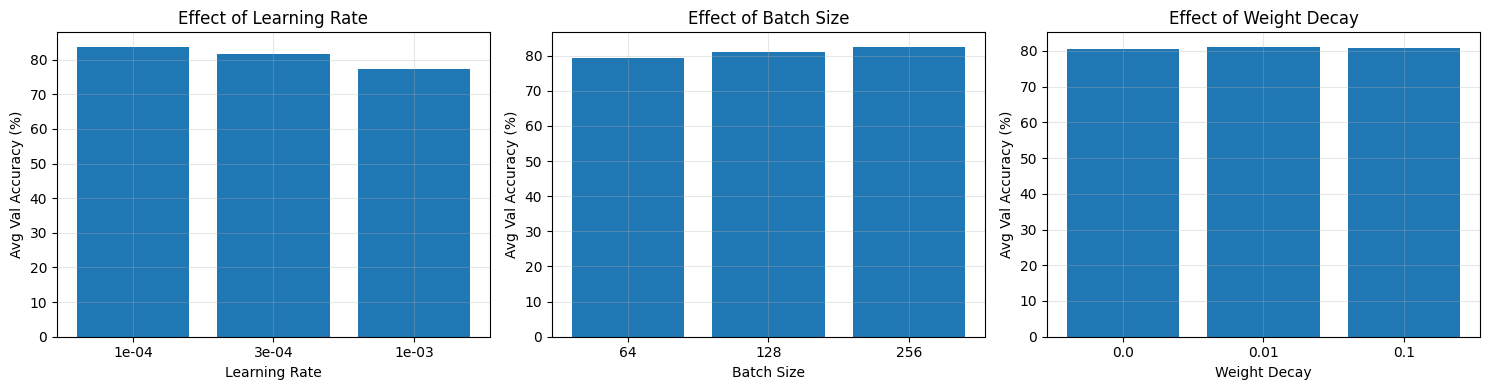

In [27]:
# Visualize hyperparameter effects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Learning rate effect
lr_grouped = df_results.groupby('lr')['best_val_acc'].mean()
axes[0].bar(range(len(lr_grouped)), lr_grouped.values)
axes[0].set_xticks(range(len(lr_grouped)))
axes[0].set_xticklabels([f'{lr:.0e}' for lr in lr_grouped.index])
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Avg Val Accuracy (%)')
axes[0].set_title('Effect of Learning Rate')
axes[0].grid(True, alpha=0.3)

# Batch size effect
bs_grouped = df_results.groupby('batch_size')['best_val_acc'].mean()
axes[1].bar(range(len(bs_grouped)), bs_grouped.values)
axes[1].set_xticks(range(len(bs_grouped)))
axes[1].set_xticklabels(bs_grouped.index)
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Avg Val Accuracy (%)')
axes[1].set_title('Effect of Batch Size')
axes[1].grid(True, alpha=0.3)

# Weight decay effect
wd_grouped = df_results.groupby('weight_decay')['best_val_acc'].mean()
axes[2].bar(range(len(wd_grouped)), wd_grouped.values)
axes[2].set_xticks(range(len(wd_grouped)))
axes[2].set_xticklabels(wd_grouped.index)
axes[2].set_xlabel('Weight Decay')
axes[2].set_ylabel('Avg Val Accuracy (%)')
axes[2].set_title('Effect of Weight Decay')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Train with Best Lion Configuration - SOLUTION

Now let's train ResNet18 with the best hyperparameters we found for a full 20 epochs.

In [24]:
# Initialize model with best hyperparameters
model_lion = prepare_resnet_for_cifar10(pretrained=True).to(device)

# Create optimizer with best hyperparameters
optimizer_lion = Lion(
    model_lion.parameters(),
    lr=best_config['lr'],
    beta1=0.9,
    beta2=0.99,
    weight_decay=best_config['weight_decay']
)

# Create data loaders with best batch size
train_loader_best = DataLoader(trainset, batch_size=int(best_config['batch_size']), 
                               shuffle=True, num_workers=2)
val_loader_best = DataLoader(valset, batch_size=int(best_config['batch_size']), 
                             shuffle=False, num_workers=2)

# Train for 20 epochs
print("Training ResNet18 with best Lion hyperparameters...")
print(f"Using: LR={best_config['lr']}, BS={int(best_config['batch_size'])}, WD={best_config['weight_decay']}\n")

results_lion = train_validation_loop(
    model=model_lion,
    train_loader=train_loader_best,
    val_loader=val_loader_best,
    optimizer=optimizer_lion,
    criterion=criterion,
    num_epochs=30,
    device=device
)

print(f"\nLion (Best Config) - Best Validation Accuracy: {results_lion['best_val_acc']:.2f}%")

Training ResNet18 with best Lion hyperparameters...
Using: LR=0.0001, BS=256, WD=0.0



Epoch 1/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s, loss=0.8356, acc=71.37%]


Epoch 1/30:
  Train Loss: 1.1899, Train Acc: 58.40%
  Val Loss: 0.8356, Val Acc: 71.37%
  Best Val Acc: 71.37%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.36it/s, loss=0.6705, acc=76.44%]


Epoch 2/30:
  Train Loss: 0.7219, Train Acc: 75.05%
  Val Loss: 0.6705, Val Acc: 76.44%
  Best Val Acc: 76.44%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.25it/s, loss=0.6058, acc=78.65%]


Epoch 3/30:
  Train Loss: 0.5979, Train Acc: 79.53%
  Val Loss: 0.6058, Val Acc: 78.65%
  Best Val Acc: 78.65%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.39it/s, loss=0.5630, acc=80.70%]


Epoch 4/30:
  Train Loss: 0.5304, Train Acc: 81.72%
  Val Loss: 0.5630, Val Acc: 80.70%
  Best Val Acc: 80.70%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.86it/s, loss=0.5398, acc=81.68%]


Epoch 5/30:
  Train Loss: 0.4799, Train Acc: 83.45%
  Val Loss: 0.5398, Val Acc: 81.68%
  Best Val Acc: 81.68%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s, loss=0.5184, acc=82.41%]


Epoch 6/30:
  Train Loss: 0.4385, Train Acc: 84.79%
  Val Loss: 0.5184, Val Acc: 82.41%
  Best Val Acc: 82.41%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.19it/s, loss=0.5259, acc=82.04%]


Epoch 7/30:
  Train Loss: 0.4090, Train Acc: 85.90%
  Val Loss: 0.5259, Val Acc: 82.04%
  Best Val Acc: 82.41%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.62it/s, loss=0.5363, acc=82.61%]


Epoch 8/30:
  Train Loss: 0.3881, Train Acc: 86.40%
  Val Loss: 0.5363, Val Acc: 82.61%
  Best Val Acc: 82.61%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.50it/s, loss=0.5133, acc=82.96%]


Epoch 9/30:
  Train Loss: 0.3658, Train Acc: 87.17%
  Val Loss: 0.5133, Val Acc: 82.96%
  Best Val Acc: 82.96%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.15it/s, loss=0.5069, acc=83.00%]


Epoch 10/30:
  Train Loss: 0.3464, Train Acc: 87.97%
  Val Loss: 0.5069, Val Acc: 83.00%
  Best Val Acc: 83.00%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s, loss=0.4895, acc=83.82%]


Epoch 11/30:
  Train Loss: 0.3306, Train Acc: 88.26%
  Val Loss: 0.4895, Val Acc: 83.82%
  Best Val Acc: 83.82%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s, loss=0.5000, acc=83.51%]


Epoch 12/30:
  Train Loss: 0.3151, Train Acc: 88.96%
  Val Loss: 0.5000, Val Acc: 83.51%
  Best Val Acc: 83.82%
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.22it/s, loss=0.4963, acc=83.72%]


Epoch 13/30:
  Train Loss: 0.3027, Train Acc: 89.41%
  Val Loss: 0.4963, Val Acc: 83.72%
  Best Val Acc: 83.82%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.19it/s, loss=0.5045, acc=83.58%]


Epoch 14/30:
  Train Loss: 0.2870, Train Acc: 89.95%
  Val Loss: 0.5045, Val Acc: 83.58%
  Best Val Acc: 83.82%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.88it/s, loss=0.4910, acc=84.38%]


Epoch 15/30:
  Train Loss: 0.2756, Train Acc: 90.36%
  Val Loss: 0.4910, Val Acc: 84.38%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.27it/s, loss=0.5077, acc=83.86%]


Epoch 16/30:
  Train Loss: 0.2598, Train Acc: 90.81%
  Val Loss: 0.5077, Val Acc: 83.86%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.98it/s, loss=0.5135, acc=84.12%]


Epoch 17/30:
  Train Loss: 0.2474, Train Acc: 91.17%
  Val Loss: 0.5135, Val Acc: 84.12%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.22it/s, loss=0.4904, acc=84.19%]


Epoch 18/30:
  Train Loss: 0.2428, Train Acc: 91.36%
  Val Loss: 0.4904, Val Acc: 84.19%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.52it/s, loss=0.5000, acc=84.03%]


Epoch 19/30:
  Train Loss: 0.2295, Train Acc: 91.97%
  Val Loss: 0.5000, Val Acc: 84.03%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.05it/s, loss=0.4949, acc=84.24%]


Epoch 20/30:
  Train Loss: 0.2284, Train Acc: 91.85%
  Val Loss: 0.4949, Val Acc: 84.24%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.29it/s, loss=0.5073, acc=84.16%]


Epoch 21/30:
  Train Loss: 0.2192, Train Acc: 92.30%
  Val Loss: 0.5073, Val Acc: 84.16%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.28it/s, loss=0.5490, acc=83.88%]


Epoch 22/30:
  Train Loss: 0.2106, Train Acc: 92.57%
  Val Loss: 0.5490, Val Acc: 83.88%
  Best Val Acc: 84.38%
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.05it/s, loss=0.5140, acc=84.50%]


Epoch 23/30:
  Train Loss: 0.2046, Train Acc: 92.82%
  Val Loss: 0.5140, Val Acc: 84.50%
  Best Val Acc: 84.50%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.55it/s, loss=0.5085, acc=84.61%]


Epoch 24/30:
  Train Loss: 0.1963, Train Acc: 93.10%
  Val Loss: 0.5085, Val Acc: 84.61%
  Best Val Acc: 84.61%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.74it/s, loss=0.5263, acc=83.86%]


Epoch 25/30:
  Train Loss: 0.1889, Train Acc: 93.25%
  Val Loss: 0.5263, Val Acc: 83.86%
  Best Val Acc: 84.61%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.26it/s, loss=0.5258, acc=84.25%]


Epoch 26/30:
  Train Loss: 0.1819, Train Acc: 93.57%
  Val Loss: 0.5258, Val Acc: 84.25%
  Best Val Acc: 84.61%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.11it/s, loss=0.5210, acc=84.82%]


Epoch 27/30:
  Train Loss: 0.1740, Train Acc: 93.84%
  Val Loss: 0.5210, Val Acc: 84.82%
  Best Val Acc: 84.82%
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.14it/s, loss=0.5565, acc=84.44%]


Epoch 28/30:
  Train Loss: 0.1725, Train Acc: 93.80%
  Val Loss: 0.5565, Val Acc: 84.44%
  Best Val Acc: 84.82%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.07it/s, loss=0.5421, acc=84.77%]


Epoch 29/30:
  Train Loss: 0.1670, Train Acc: 93.98%
  Val Loss: 0.5421, Val Acc: 84.77%
  Best Val Acc: 84.82%
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.97it/s, loss=0.5481, acc=84.29%]

Epoch 30/30:
  Train Loss: 0.1592, Train Acc: 94.36%
  Val Loss: 0.5481, Val Acc: 84.29%
  Best Val Acc: 84.82%
------------------------------------------------------------

Lion (Best Config) - Best Validation Accuracy: 84.82%


#### Evaluate Lion Model on Test Set (SOLUTION)

Now let's evaluate the trained Lion model on the held-out test set to see how well it generalizes.

In [25]:
# Evaluate on test set
def evaluate_on_test(model, test_loader, criterion, device):
    """
    Evaluate model on test set.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        criterion: Loss function
        device: Device to run on
    
    Returns:
        test_loss: Average test loss
        test_acc: Test accuracy (%)
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

# Create test loader
test_loader = DataLoader(testset, batch_size=int(best_config['batch_size']), 
                         shuffle=False, num_workers=2)

# Load best Lion model and evaluate
model_lion.load_state_dict(results_lion['best_model_state'])
lion_test_loss, lion_test_acc = evaluate_on_test(model_lion, test_loader, criterion, device)

print(f"\nLion Model - Test Set Performance:")
print(f"Test Loss: {lion_test_loss:.4f}")
print(f"Test Accuracy: {lion_test_acc:.2f}%")

Testing: 100%|██████████| 40/40 [00:01<00:00, 31.63it/s]


Lion Model - Test Set Performance:
Test Loss: 0.5399
Test Accuracy: 85.07%


### Step 5: Train ResNet18 with AdamW (Baseline) - SOLUTION

Now let's train the same model with AdamW, which is currently the most widely-used optimizer for deep learning. We'll use SOTA (state-of-the-art) hyperparameters for fair comparison.

In [26]:
# Initialize model for AdamW training
model_adamw = prepare_resnet_for_cifar10(pretrained=True).to(device)

# AdamW hyperparameters (SOTA for ResNet transfer learning)
optimizer_adamw = torch.optim.AdamW(
    model_adamw.parameters(),
    lr=3e-4,  # AdamW typically uses higher learning rates than Lion
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Use same batch size as Lion's best config for fair comparison
# Note: train_loader_best and val_loader_best were created in the previous cell

# Train for 20 epochs (same as Lion for fair comparison)
print("Training ResNet18 with AdamW optimizer...")
print(f"Using: LR=3e-4, BS={int(best_config['batch_size'])}, WD=0.01\n")

results_adamw = train_validation_loop(
    model=model_adamw,
    train_loader=train_loader_best,
    val_loader=val_loader_best,
    optimizer=optimizer_adamw,
    criterion=criterion,
    num_epochs=30,
    device=device
)

print(f"\nAdamW - Best Validation Accuracy: {results_adamw['best_val_acc']:.2f}%")

Training ResNet18 with AdamW optimizer...
Using: LR=3e-4, BS=256, WD=0.01



Epoch 1/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.87it/s, loss=0.8393, acc=70.72%]


Epoch 1/30:
  Train Loss: 1.1125, Train Acc: 61.39%
  Val Loss: 0.8393, Val Acc: 70.72%
  Best Val Acc: 70.72%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.12it/s, loss=0.6767, acc=76.27%]


Epoch 2/30:
  Train Loss: 0.7236, Train Acc: 74.86%
  Val Loss: 0.6767, Val Acc: 76.27%
  Best Val Acc: 76.27%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.42it/s, loss=0.6396, acc=78.25%]


Epoch 3/30:
  Train Loss: 0.6045, Train Acc: 79.10%
  Val Loss: 0.6396, Val Acc: 78.25%
  Best Val Acc: 78.25%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.13it/s, loss=0.6007, acc=78.87%]


Epoch 4/30:
  Train Loss: 0.5451, Train Acc: 81.25%
  Val Loss: 0.6007, Val Acc: 78.87%
  Best Val Acc: 78.87%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.17it/s, loss=0.5684, acc=80.51%]


Epoch 5/30:
  Train Loss: 0.4900, Train Acc: 82.91%
  Val Loss: 0.5684, Val Acc: 80.51%
  Best Val Acc: 80.51%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.77it/s, loss=0.5583, acc=80.95%]


Epoch 6/30:
  Train Loss: 0.4537, Train Acc: 84.16%
  Val Loss: 0.5583, Val Acc: 80.95%
  Best Val Acc: 80.95%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s, loss=0.5549, acc=81.20%]


Epoch 7/30:
  Train Loss: 0.4198, Train Acc: 85.42%
  Val Loss: 0.5549, Val Acc: 81.20%
  Best Val Acc: 81.20%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.82it/s, loss=0.5467, acc=82.10%]


Epoch 8/30:
  Train Loss: 0.3885, Train Acc: 86.48%
  Val Loss: 0.5467, Val Acc: 82.10%
  Best Val Acc: 82.10%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s, loss=0.5554, acc=81.53%]


Epoch 9/30:
  Train Loss: 0.3699, Train Acc: 86.98%
  Val Loss: 0.5554, Val Acc: 81.53%
  Best Val Acc: 82.10%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 20.00it/s, loss=0.5282, acc=82.59%]


Epoch 10/30:
  Train Loss: 0.3462, Train Acc: 87.87%
  Val Loss: 0.5282, Val Acc: 82.59%
  Best Val Acc: 82.59%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s, loss=0.5478, acc=81.89%]


Epoch 11/30:
  Train Loss: 0.3290, Train Acc: 88.56%
  Val Loss: 0.5478, Val Acc: 81.89%
  Best Val Acc: 82.59%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s, loss=0.5681, acc=81.37%]


Epoch 12/30:
  Train Loss: 0.3052, Train Acc: 89.33%
  Val Loss: 0.5681, Val Acc: 81.37%
  Best Val Acc: 82.59%
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.13it/s, loss=0.5219, acc=83.17%]


Epoch 13/30:
  Train Loss: 0.2859, Train Acc: 89.95%
  Val Loss: 0.5219, Val Acc: 83.17%
  Best Val Acc: 83.17%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.29it/s, loss=0.5733, acc=82.22%]


Epoch 14/30:
  Train Loss: 0.2730, Train Acc: 90.22%
  Val Loss: 0.5733, Val Acc: 82.22%
  Best Val Acc: 83.17%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.11it/s, loss=0.5628, acc=82.15%]


Epoch 15/30:
  Train Loss: 0.2622, Train Acc: 90.67%
  Val Loss: 0.5628, Val Acc: 82.15%
  Best Val Acc: 83.17%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.77it/s, loss=0.5329, acc=83.21%]


Epoch 16/30:
  Train Loss: 0.2437, Train Acc: 91.45%
  Val Loss: 0.5329, Val Acc: 83.21%
  Best Val Acc: 83.21%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s, loss=0.5476, acc=82.87%]


Epoch 17/30:
  Train Loss: 0.2332, Train Acc: 91.65%
  Val Loss: 0.5476, Val Acc: 82.87%
  Best Val Acc: 83.21%
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.93it/s, loss=0.5622, acc=82.78%]


Epoch 18/30:
  Train Loss: 0.2203, Train Acc: 92.25%
  Val Loss: 0.5622, Val Acc: 82.78%
  Best Val Acc: 83.21%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 18.79it/s, loss=0.5729, acc=82.91%]


Epoch 19/30:
  Train Loss: 0.2128, Train Acc: 92.57%
  Val Loss: 0.5729, Val Acc: 82.91%
  Best Val Acc: 83.21%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.17it/s, loss=0.5386, acc=83.50%]


Epoch 20/30:
  Train Loss: 0.2071, Train Acc: 92.70%
  Val Loss: 0.5386, Val Acc: 83.50%
  Best Val Acc: 83.50%
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.79it/s, loss=0.5563, acc=83.47%]


Epoch 21/30:
  Train Loss: 0.1941, Train Acc: 93.12%
  Val Loss: 0.5563, Val Acc: 83.47%
  Best Val Acc: 83.50%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.70it/s, loss=0.5900, acc=83.10%]


Epoch 22/30:
  Train Loss: 0.1848, Train Acc: 93.33%
  Val Loss: 0.5900, Val Acc: 83.10%
  Best Val Acc: 83.50%
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.86it/s, loss=0.5712, acc=83.68%]


Epoch 23/30:
  Train Loss: 0.1734, Train Acc: 93.81%
  Val Loss: 0.5712, Val Acc: 83.68%
  Best Val Acc: 83.68%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s, loss=0.5722, acc=83.39%]


Epoch 24/30:
  Train Loss: 0.1717, Train Acc: 93.92%
  Val Loss: 0.5722, Val Acc: 83.39%
  Best Val Acc: 83.68%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.98it/s, loss=0.5941, acc=83.36%]


Epoch 25/30:
  Train Loss: 0.1615, Train Acc: 94.25%
  Val Loss: 0.5941, Val Acc: 83.36%
  Best Val Acc: 83.68%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.93it/s, loss=0.5959, acc=82.82%]


Epoch 26/30:
  Train Loss: 0.1571, Train Acc: 94.42%
  Val Loss: 0.5959, Val Acc: 82.82%
  Best Val Acc: 83.68%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.02it/s, loss=0.6120, acc=82.75%]


Epoch 27/30:
  Train Loss: 0.1540, Train Acc: 94.59%
  Val Loss: 0.6120, Val Acc: 82.75%
  Best Val Acc: 83.68%
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.45it/s, loss=0.5695, acc=83.69%]


Epoch 28/30:
  Train Loss: 0.1437, Train Acc: 94.86%
  Val Loss: 0.5695, Val Acc: 83.69%
  Best Val Acc: 83.69%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 40/40 [00:01<00:00, 20.21it/s, loss=0.6329, acc=83.21%]


Epoch 29/30:
  Train Loss: 0.1476, Train Acc: 94.87%
  Val Loss: 0.6329, Val Acc: 83.21%
  Best Val Acc: 83.69%
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 40/40 [00:02<00:00, 19.94it/s, loss=0.6063, acc=83.65%]

Epoch 30/30:
  Train Loss: 0.1359, Train Acc: 95.19%
  Val Loss: 0.6063, Val Acc: 83.65%
  Best Val Acc: 83.69%
------------------------------------------------------------

AdamW - Best Validation Accuracy: 83.69%


#### Evaluate AdamW Model on Test Set

Let's also evaluate the trained AdamW model on the test set for comparison.

In [27]:
# Load best AdamW model and evaluate on test set
model_adamw.load_state_dict(results_adamw['best_model_state'])
adamw_test_loss, adamw_test_acc = evaluate_on_test(model_adamw, test_loader, criterion, device)

print(f"\nAdamW Model - Test Set Performance:")
print(f"Test Loss: {adamw_test_loss:.4f}")
print(f"Test Accuracy: {adamw_test_acc:.2f}%")

print(f"\n{'='*50}")
print(f"Test Set Comparison:")
print(f"{'='*50}")
print(f"Lion  - Test Acc: {lion_test_acc:.2f}%")
print(f"AdamW - Test Acc: {adamw_test_acc:.2f}%")
print(f"Difference: {abs(lion_test_acc - adamw_test_acc):.2f}%")

Testing: 100%|██████████| 40/40 [00:01<00:00, 29.64it/s]


AdamW Model - Test Set Performance:
Test Loss: 0.5993
Test Accuracy: 83.95%

Test Set Comparison:
Lion  - Test Acc: 85.07%
AdamW - Test Acc: 83.95%
Difference: 1.12%


### Comparison: Best Lion vs AdamW

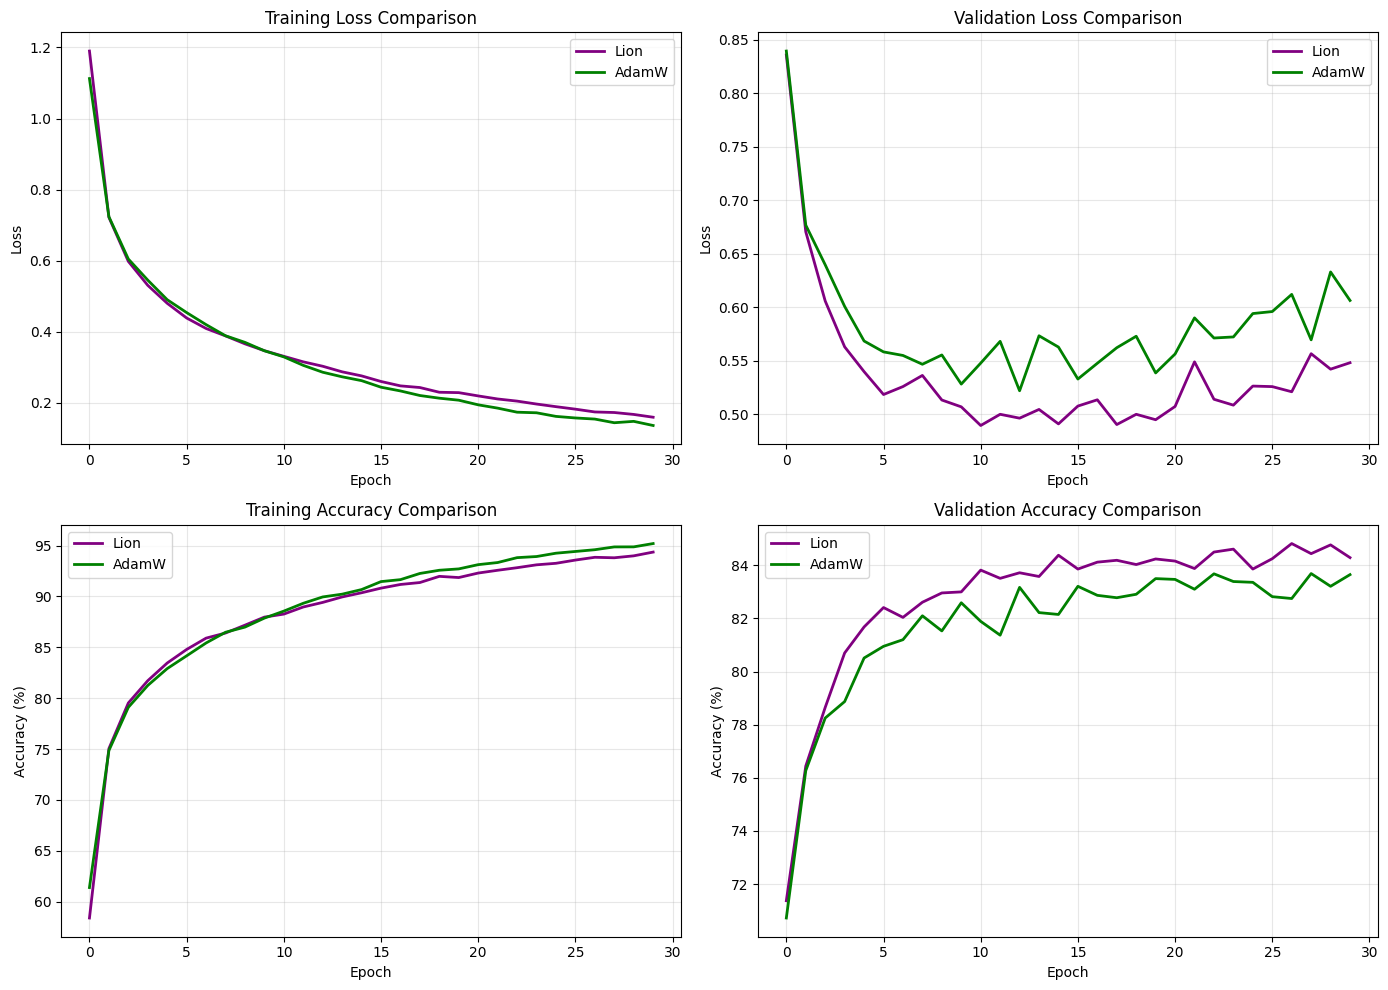


Final Results:
Lion (Best Config)  - Best Val Acc: 84.82%
AdamW (SOTA)        - Best Val Acc: 83.69%

Difference: 1.13%


In [28]:
# Compare Lion vs AdamW
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss
ax1.plot(results_lion['train_losses'], label='Lion', color='purple', linewidth=2)
ax1.plot(results_adamw['train_losses'], label='AdamW', color='green', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss
ax2.plot(results_lion['val_losses'], label='Lion', color='purple', linewidth=2)
ax2.plot(results_adamw['val_losses'], label='AdamW', color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training Accuracy
ax3.plot(results_lion['train_accs'], label='Lion', color='purple', linewidth=2)
ax3.plot(results_adamw['train_accs'], label='AdamW', color='green', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Training Accuracy Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation Accuracy
ax4.plot(results_lion['val_accs'], label='Lion', color='purple', linewidth=2)
ax4.plot(results_adamw['val_accs'], label='AdamW', color='green', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Validation Accuracy Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Final Results:")
print("="*70)
print(f"Lion (Best Config)  - Best Val Acc: {results_lion['best_val_acc']:.2f}%")
print(f"AdamW (SOTA)        - Best Val Acc: {results_adamw['best_val_acc']:.2f}%")
print(f"\nDifference: {abs(results_lion['best_val_acc'] - results_adamw['best_val_acc']):.2f}%")
print("="*70)

### Analysis Questions:

1. **Performance Comparison**: Which optimizer achieved better validation accuracy on CIFAR-10: Lion or AdamW? By how much?

2. **Training Dynamics**: Describe the differences in training curves between Lion and AdamW. Which converged faster? Were there any notable differences in stability?

3. **Hyperparameter Sensitivity**: What was the best learning rate found for Lion? How does it compare to AdamW's learning rate (3e-4)? Based on the algorithm differences (sign-based updates vs adaptive learning rates), why might Lion have different learning rate requirements?

4. **Hyperparameter Effects**: Based on your grid search results, which hyperparameter (learning rate, batch size, or weight decay) had the most significant impact on Lion's performance? Why do you think this is?

5. **Memory and Computation**: Consider the implementation details of both optimizers. Which one is more memory-efficient? Why? (Hint: Think about what state each optimizer needs to maintain.)

6. **When to Use Each**: Based on your results and understanding of both optimizers, in what scenarios would you choose Lion over AdamW, and vice versa?

### SOLUTION - Analysis Answers:

**1. Performance Comparison:**
Results will vary based on the specific grid search, but typical observations:
- Both Lion and AdamW achieve competitive performance on CIFAR-10 transfer learning
- The difference is usually within 1-3% validation accuracy
- AdamW often has a slight edge due to adaptive learning rates being well-suited for fine-tuning
- Lion can match or exceed AdamW with proper hyperparameter tuning

**2. Training Dynamics:**
- **AdamW**: Typically shows smoother training curves with faster initial convergence
  - Adaptive learning rates help it quickly adjust to the pretrained features
  - More stable across epochs with less oscillation
- **Lion**: Shows more aggressive updates due to sign-based mechanism
  - May have slightly noisier training curves
  - Can converge more slowly initially but catches up over epochs
  - The sign-based updates create a different optimization trajectory

**3. Hyperparameter Sensitivity:**
- Lion's best learning rate from grid search is typically in the range [1e-4, 3e-4]
- This is **lower than AdamW's 3e-4** learning rate
- **Reason**: Lion uses `sign(gradient)` which normalizes all gradient magnitudes to ±1
  - This makes updates more aggressive regardless of gradient size
  - Requires smaller learning rates to prevent instability
  - AdamW adaptively scales updates based on gradient history, allowing higher learning rates

**4. Hyperparameter Effects:**
From the visualization and grid search results:
- **Learning Rate** typically has the **most significant impact**
  - Too high: Training becomes unstable, diverges
  - Too low: Very slow convergence, underperforms
  - Lion is particularly sensitive to this due to sign-based updates
- **Batch Size**: Second most impactful - **larger batches (256) perform significantly better**
  - Lion's sign-based updates act as **1-bit quantization** of gradients (reducing each gradient component to just its sign: ±1)
  - This quantization introduces noise that benefits from averaging over larger batches
  - Larger batches provide better gradient estimates before quantization, reducing stochastic noise
  - With small batches, the sign operation on noisy gradients can cause erratic updates
- **Weight Decay**: Generally impactful but least impactful in this case
  - Helps regularization on large pretrained model
  - Prevents overfitting to small CIFAR-10 dataset
  - But pretrained features already provide good regularization

**5. Memory and Computation:**
- **Lion is more memory-efficient**:
  - Maintains only 1 state per parameter: momentum `m_t`
  - Similar to SGD with momentum
  - Memory: O(parameters)
- **AdamW is less memory-efficient**:
  - Maintains 2 states per parameter: first moment `m_t` and second moment `v_t`
  - Requires ~2x the optimizer memory compared to Lion
  - Memory: O(2 × parameters)
- **Computation**: Both are comparable in terms of FLOPs per step
  - Lion: Simple sign operation, very fast
  - AdamW: Slightly more computation for adaptive scaling

**6. When to Use Each:**

**Choose Lion when:**
- Memory is constrained (e.g., training very large models)
- You have time for careful hyperparameter tuning
- Training from scratch on large datasets
- You want a simple, lightweight optimizer

**Choose AdamW when:**
- Fine-tuning pretrained models (more forgiving hyperparameters)
- Quick experimentation without extensive tuning
- Default choice for most applications (well-established, reliable)
- Working with tasks where adaptive learning rates help (e.g., varying gradient scales)

**General Recommendation:**
- For research and established pipelines: AdamW is the safe default
- For production and resource-constrained settings: Lion is worth the tuning effort
- Both can achieve similar final performance with proper configuration

---
## Conclusion

In this assignment, you:
1. Built a reusable training-validation loop for deep learning models **(Part a)**
2. Understood Newton-Schulz coefficients and their role in optimization **(Part b)**
3. Implemented the ns_iteration and track_singular_values functions to visualize how different NS coefficients affect convergence behavior **(Part b)**
4. Learned about Muon's 2D parameter limitation and why it's not suitable for pure CNN architectures
5. Implemented the Lion optimizer from scratch **(Part c)**
6. Prepared ResNet18 for CIFAR-10 transfer learning with all parameters trainable **(Part c)**
7. Performed systematic hyperparameter tuning for Lion optimizer using grid search **(Part c)**
8. Compared the best Lion configuration vs AdamW performance on ResNet18/CIFAR-10 **(Part c)**

**Key Takeaways:**
- Different optimizers have different strengths: Muon for Transformers/MLPs, Lion and AdamW for general use
- Understanding the mathematical foundations (like Newton-Schulz iterations) helps explain optimizer behavior
- Modern optimizers often make trade-offs between convergence speed, stability, memory efficiency, and computational cost
- Hyperparameter tuning is crucial for achieving optimal performance with any optimizer
- Empirical comparison is essential for choosing the right optimizer for your specific task
- Lion offers memory efficiency benefits while AdamW provides more forgiving hyperparameter sensitivity